In [1]:
%matplotlib inline
import fasta_subseq_2 as fa
import seq_plotmethods as sp
import itertools as it
import tables as tb
import numpy as np
import subprocess as subp
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import gzip
import tarfile
import re
import patser_tools as pat
#import matplotlib_venn as vn 
import os
import shutil
from __future__ import division
from skimage import io as skio
from skimage import transform as skxform

# set up plotting environment for LaTeX compatability
plt.rc('text', usetex = False)
plt.rc('font', family = 'serif')

# Define chromosome names for dmel and dpse
DMEL_CHRS = ['2L','2R','3L','3R','X','YHet','4','2LHet','2RHet','3LHet','3RHet','XHet','U','Uextra']
DMEL_CHRS_EU = ['2L','2R','3L','3R','X']

current_dir = "/Users/barricklab/Dropbox/Documents/Manuscripts/slicing/analysis_notebook/"
genomes_dir = current_dir + "genomes/"
reads_dir = current_dir + "reads/"
data_out_dir = current_dir + "data/"
figs_dir = current_dir + "figs/"
scripts_dir = current_dir + "scripts/"
mapping_dir = data_out_dir + "mapping/"
peaks_dir = data_out_dir + "peaks/"
h5_dir = data_out_dir + "hf5/"



In [2]:
def df_set_diff(df1,df2):
    df1_set = set([ tuple(line) for line in df1.values.tolist()])
    df2_set = set([ tuple(line) for line in df2.values.tolist()])
    df1_df2_diff = df1_set.difference(df2_set)
    return pd.DataFrame(list(df1_df2_diff))

def df_pk_overlap(df,pk,dfchr='chr',pkchr='chr',dfst='start',pkst='start',dfend='end',pkend='end',pkwin=0):
    pk_start = pk[pkst] - pkwin
    pk_end = pk[pkend] + pkwin
    return df.loc[((df[dfchr] == pk[pkchr]) &
                   ((((df[dfst] >= pk_start) & (df[dfst] <= pk_end)) |
                     ((df[dfend] >= pk_start) & (df[dfend] <= pk_end))) |
                    (((pk_start >= df[dfst]) & (pk_start <= df[dfend])) & 
                     ((pk_end >= df[dfst]) & (pk_end <= df[dfend])))) )]

def calculate_pk_pk_overlap(pk_overlap_df,pk1_start_col='start',pk1_end_col='end',pk2_start_col='enh_start',pk2_end_col='enh_end'):
    overlap = []
    for i in range(0,len(pk_overlap_df)):
        r = pk_overlap_df.iloc[i]
        pk_length = float(r[pk1_end_col] - r[pk1_start_col])
        frac_overlap = 0
        if (r[pk2_end_col] < r[pk1_end_col]) and r[pk2_start_col] > r[pk1_start_col]:
            frac_overlap = (r[pk2_end_col] - r[pk2_start_col]) / pk_length
        elif (r[pk1_end_col] < r[pk2_end_col]) and r[pk1_start_col] > r[pk2_start_col]:
            frac_overlap =  (r[pk1_end_col] - r[pk1_start_col]) / pk_length
        elif (r[pk2_end_col] < r[pk1_end_col]):
            frac_overlap = (r[pk2_end_col] - r[pk1_start_col]) / pk_length
        elif (r[pk2_start_col] > r[pk1_start_col]):
            frac_overlap = (r[pk1_end_col] - r[pk2_start_col]) / pk_length
        overlap.append(frac_overlap)
    pk_overlap_df.loc[:,"Overlap"] = overlap


def check_overlap(pk1,pk2,allowed):
    ol = sp.overlap(pk1,pk2)
    ol_len = ol[1] - ol[0]
    return (ol_len/pk2['len'] < allowed)

def trim_enhancer_list(enh_df,allowed_ol=0.1):
    enh_df_srt = enh_df.sort(columns=['len'])
    trimmed_set = pd.DataFrame(columns=enh_df_srt.columns)
    tr_ix = 0
    for (ix,e) in enh_df.iterrows():
        trimmed_ol = df_pk_overlap(trimmed_set,e)
        if trimmed_ol.shape[0] > 0:
            trimmed_ol['ol_pass'] = trimmed_ol.apply(check_overlap,args=[e,allowed_ol],axis=1)
            if not all(trimmed_ol['ol_pass']):
                print "%s Not Passed" % (e['name'],)
                continue
        e.name = e['name']
        trimmed_set = trimmed_set.append(e,ignore_index=True)
        tr_ix += 1
        print "%s Passed, trimmed set length: %d" % (e['name'],trimmed_set.shape[0])
    return trimmed_set

class chipExpt():
    def __init__(self,group,name="NoName",chrs=DMEL_CHRS_EU,chr_ext='ext'):
        self.chr_dict = {}
        self.group = group
        self.name = name
        arrays = group._v_children.items()
        if chrs:
            for ch in chrs:
                chr_found = 0
                for (name,node) in arrays:
                    if re.search(chr_ext + "\w*_(chr)?"+ch+"$",name):
                        #print (ch,name,node.name)
                        chr_found = 1
                        self.chr_dict[ch] = node
                        break
                if chr_found == 0:
                    print "no chr found for %s" % (ch,)
        else:
            for n in group._f_walkNodes():
                ch_s = re.search("chr(.+)",n.name)
                self.chr_dict[ch_s.group(1)] = n
                break
                    
    def __getitem__(self,item):
        return self.chr_dict[item]

    def write_wig(self,chr_convert=None,span=10,outfile=None):
        if outfile == None:
            outfile = self.name + ".wig"
        wigout = open(outfile,"w")
        print >> wigout, "track type=wiggle_0 name=%s description=%s visibility=full autoScale=off maxHeightPixels=100:50:20" % (self.name,self.name)
        for (chrom,chr_arr) in self.chr_dict.items():
            print "Writing %s..." % (chrom,),
            name = chrom
            if chr_convert != None:
                name = chr_convert[chrom]
            print >> wigout, "variableStep chrom=%s span=%d" % (name,span)
            for i in np.arange(1,len(chr_arr),step=span):
                print >> wigout, "%d\t%f" % (i,np.sum(chr_arr[i:i+span])/float(span))
            print "done!"
        wigout.close()

In [3]:
def set_figsize(x,y):
    curfig = plt.gcf()
    curfig.set_figwidth(x)
    curfig.set_figheight(y)

def replace_nw(match):
    return "\\" + match.group(1)

def stacked_plots_w_highlight_pk(peak_dict,pad,h_regions,gff,sum_fn,sum_tracks,add_sum_to_tracks,sum_label,norm_expt,*expts):
    pk_chr = peak_dict['chr']
    pk_start = peak_dict['start'] - pad
    pk_end = peak_dict['end'] + pad
    stacked_plots_w_highlight(pk_chr,pk_start,pk_end,h_regions,gff,sum_fn,sum_tracks,add_sum_to_tracks,sum_label,norm_expt,*expts)

def stacked_plots_w_highlight(chr,start,end,h_regions,gff,sum_fn,sum_tracks,add_sum_to_tracks,sum_label,norm_expt,*expts):
    style=sp.get_line_style()
    ymax = 1.0
    if len(norm_expt) < len(expts): 
        ymax = max([(max(ex[chr][start:end])*1.2) for (n,ex) in enumerate(expts) if n not in norm_expt])
    ylimits = (0,ymax)
    
    
    genes = gff.get_region_annot(chr,start,end,"gene")['gene']
    
    print ymax
    
    for (i,x) in enumerate(expts):
        #shape = int(str(len(expts)) + "1" + str(i + 1))
        plt.subplot(len(expts),1,i+1)
        plotted_genes = []
        text_coords = np.linspace(ymax,0,num=len(h_regions)+2)[1:-1]
        
        if i in norm_expt:
            #ylim(0,1.2)
            sp.plot_genome_region(chr,start,end,style,x)
        else:
            plt.ylim(ylimits)
            sp.plot_genome_region(chr,start,end,style,x)
            
        if i in add_sum_to_tracks:
            print sum_fn([y[chr][start:end] for (i,y) in enumerate(expts) if i in sum_tracks])
            plt.plot(np.arange(start,end),sum_fn([y[chr][start:end] for (i,y) in enumerate(expts) if i in sum_tracks]),"k--",alpha=0.7,linewidth=3,label=sum_label)
            plt.legend()
            #plt.xlim(start,end)
        
        for (s,h) in zip(text_coords,h_regions):
            if (h['end'] < start) or (h['start'] > end):
                continue
            plt.axvspan(h['start'], h['end'], facecolor='k', alpha=0.2)
            h_region_name = ""
            try:
                h_region_name = re.sub("((\W|_))",replace_nw,h['name'])
            except KeyError:
                h_region_name = "%s:%d-%d" % (h['chr'],h['start'],h['end'])
            print h_region_name
            ann_xy = ((h['start'] + h['end'])/2,plt.ylim()[1]/2) 
            text_xy = (h['start'],s)
            plt.annotate(h_region_name,xy=ann_xy,xytext=text_xy) 

        for g in genes:
            pad = 0
            g['chr'] = '-'
            for gn in plotted_genes:
                if sp.overlap(g,gn) != (0,0):
                    pad = gn['pad'] + .11
            plt.axvspan(g['start'], g['end'], ymin=0.025+pad,ymax=0.125+pad,facecolor='g', alpha=0.2)
            annot_coords = ((g['start'] + g['end'])/2.0,(0.075+pad)*ymax)
            gene_name_direction = g['name'] + r'$\quad \longrightarrow$'
            if g['strand'] == '-':
                gene_name_direction = '$\longleftarrow \quad$' + g['name']
            plt.annotate(gene_name_direction,xy=annot_coords,xytext=(0,20),textcoords='offset points',
                     arrowprops=None, ha='center', va='center')
            g['pad'] = pad
            plotted_genes.append(g)
            print plotted_genes
            
def ax1_mean(expts):
    expt_ar = np.vstack(expts)
    return np.mean(expt_ar,axis=0)

def two_exp_diff(expts):
    return expts[0] - expts[1]

In [4]:
gff_h5 = h5_dir + "/gff.h5"
gff_dmel = sp.GFFtable(genomes_dir + "/dmel-all-r5.17_genes.gff",gff_h5,DMEL_CHRS_EU,"gene")
# giant ChIP
gtAm_h5 = tb.open_file(h5_dir+'gtA_dmel.h5', mode='r+')
gtPm_h5 = tb.open_file(h5_dir+'gtP_dmel.h5', mode='r+')
gtCm_h5 = tb.open_file(h5_dir+'gtC_dmel.h5', mode='r+')
gtW1m_h5 = tb.open_file(h5_dir+'gtW1_dmel.h5', mode='r+')
gtW2m_h5 = tb.open_file(h5_dir+'gtW2_dmel.h5', mode='r+')

# Load dmel input data - concatenated reads from all input samples
inAllm_h5 = tb.open_file(h5_dir+'inAll_dmel.h5', mode='r+')

# make chipExpt objects for all above (tag-normed and raw counts)
gtAm_tn = chipExpt(gtAm_h5.root.tag_counts.ext_tags,"Dmel Ant GT ChIP, tag-normalized")
gtPm_tn = chipExpt(gtPm_h5.root.tag_counts.ext_tags,"Dmel Post GT ChIP, tag-normalized")
gtCm_tn = chipExpt(gtCm_h5.root.tag_counts.ext_tags,"Dmel Combo GT ChIP, tag-normalized")
gtW1m_tn = chipExpt(gtW1m_h5.root.tag_counts.ext_tags,"Dmel Whole Rep1 GT ChIP, tag-normalized")
gtW2m_tn = chipExpt(gtW2m_h5.root.tag_counts.ext_tags,"Dmel Whole Rep2 GT ChIP, tag-normalized")

# Load Peak Data
try:
    pks_h5 = tb.open_file(peaks_dir+"/peaks.h5","w")
except ValueError:
    pks_h5.close()
    pks_h5 = tb.open_file(peaks_dir+"/peaks.h5","w")

# GT peaks    
gtAm_pks_tb = sp.read_macs(pks_h5,peaks_dir+"gtA_dmel_peaks.xls",expt_name="gtAm_pks")
gtPm_pks_tb = sp.read_macs(pks_h5,peaks_dir+"gtP_dmel_peaks.xls",expt_name="gtPm_pks")
gtCm_pks_tb = sp.read_macs(pks_h5,peaks_dir+"gtC_dmel_peaks.xls",expt_name="gtCm_pks")
gtW1m_pks_tb = sp.read_macs(pks_h5,peaks_dir+"gtW1_dmel_peaks.xls",expt_name="gtW1m_pks")
gtW2m_pks_tb = sp.read_macs(pks_h5,peaks_dir+"gtW2_dmel_peaks.xls",expt_name="gtW2m_pks")

gtAm_pks = [x for x in sp.pks_to_dict(gtAm_pks_tb) if x['chr'] in DMEL_CHRS_EU]
gtPm_pks = [x for x in sp.pks_to_dict(gtPm_pks_tb) if x['chr'] in DMEL_CHRS_EU]
gtCm_pks = [x for x in sp.pks_to_dict(gtCm_pks_tb) if x['chr'] in DMEL_CHRS_EU]
gtW1m_pks = [x for x in sp.pks_to_dict(gtW1m_pks_tb) if x['chr'] in DMEL_CHRS_EU]
gtW2m_pks = [x for x in sp.pks_to_dict(gtW2m_pks_tb) if x['chr'] in DMEL_CHRS_EU]

(gtm_un0_pks,gtm_in0_pks,gtm_OL0_pks) = sp.peak_union(0,0,['gtAm','gtPm','gtCm','gtW1m','gtW2m'],True,gtAm_pks,gtPm_pks,gtCm_pks,gtW1m_pks,gtW2m_pks)
gtm_5wy_OLs = [x for x in gtm_in0_pks if len(set(x['sets'])) == 5]
print "GT Dmel Final 5-way overlaps: %d" % (len(gtm_5wy_OLs))

# Get matching peak sets from each GT dataset
(top1000gtW1m_5wy_OL_pi,top1000gtW1m_5wy_OL) = zip(*sp.get_top_n_peaks(1000,gtm_5wy_OLs,gtW1m_tn))
gtAm_top1000gtW1m_5OL_tn = sp.make_array_from_peaks('ns',top1000gtW1m_5wy_OL,gtAm_tn)
gtPm_top1000gtW1m_5OL_tn = sp.make_array_from_peaks('ns',top1000gtW1m_5wy_OL,gtPm_tn)
gtW1m_top1000gtW1m_5OL_tn = sp.make_array_from_peaks('ns',top1000gtW1m_5wy_OL,gtW1m_tn)
gtW2m_top1000gtW1m_5OL_tn = sp.make_array_from_peaks('ns',top1000gtW1m_5wy_OL,gtW2m_tn)
gtCm_top1000gtW1m_5OL_tn = sp.make_array_from_peaks('ns',top1000gtW1m_5wy_OL,gtCm_tn)

# Get 5-way union peak sets from each GT experiment
gtAm_5un_tn = sp.make_array_from_peaks('ns',gtm_un0_pks,gtAm_tn)
gtPm_5un_tn = sp.make_array_from_peaks('ns',gtm_un0_pks,gtPm_tn)
gtW1m_5un_tn = sp.make_array_from_peaks('ns',gtm_un0_pks,gtW1m_tn)
gtW2m_5un_tn = sp.make_array_from_peaks('ns',gtm_un0_pks,gtW2m_tn)
gtCm_5un_tn = sp.make_array_from_peaks('ns',gtm_un0_pks,gtCm_tn)



Peak window (peak width +/- 0)
Starting Sets:
	gtAm :     3000 peaks
	gtPm :      915 peaks
	gtCm :     1870 peaks
	gtW1m :     1629 peaks
	gtW2m :     1557 peaks
8971 total peaks in starting set
3333 in union, 2022 in intersect
final isct: 2022 before filtering, 2022 after
total overlapping peaks (all sets): 4044
By-Experiment Overlap Counts:
	gtPm :      165
	gtCm :     1054
	gtW2m :      380
	gtW1m :      745
	gtAm :     1700
GT Dmel Final 5-way overlaps: 634


In [ ]:
gtA_APfdr1_pks = pd.read_csv(data_out_dir + '/supp_data/gtA_fdr1_pkbind.tsv',delimiter='\t')
gtP_APfdr1_pks = pd.read_csv(data_out_dir + '/supp_data/gtP_fdr1_pkbind.tsv',delimiter='\t')
gtNoBias_highbind_pks = pd.read_csv(data_out_dir + '/supp_data/gtALL_fdr1_notcp_highpkbind.tsv',delimiter='\t')
gtBias_APfdr1_pks = gtA_APfdr1_pks.append(gtP_APfdr1_pks,ignore_index=True)
gtALL_highbind_pks = gtBias_APfdr1_pks.append(gtNoBias_highbind_pks,ignore_index=True)
gtNoBias_highbind_pks

CHR     START       END    SUMMIT  LENGTH  AP_NORM_DIFF  AP_DIFF_PVAL  \
0    2L  14435778  14436756  14436334     978           0.0           0.0   
1    3R   2710948   2711546   2711224     598           0.0           0.0   
2    3R   2683204   2684016   2683520     812           0.0           0.0   
3    2R   2009468   2010075   2009623     607           0.0           0.0   
4    2L  18943829  18944151  18943979     322           0.0           0.0   
5    3R   1036835   1038080   1037491    1245           0.0           0.0   
6    3R  11182767  11183194  11182970     427           0.0           0.0   
7    3R   2733802   2734207   2733992     405           0.0           0.0   
8    3R  24161215  24161763  24161554     548           0.0           0.0   
9    2R   9447696   9450212   9448603    2516           0.0           0.0   
10   2L  21104908  21105563  21105356     655           0.0           0.0   
11   3R    802499    802907    802712     408           0.0           0.0   
12   3R  12076300  12076658  12076422     358           0.0           0.0   
13   3R  11972256  11972840  11972437     584           0.0           0.0   
14    X  12629717  12630293  12630083     576           0.0           0.0   
15    X   8189528   8189906   8189748     378           0.0           0.0   
16   3L  14445439  14446158  14445957     719           0.0           0.0   
17   2R  18970983  18971408  18971176     425           0.0           0.0   
18   3R   5381312   5381743   5381498     431           0.0           0.0   
19   3L  19553952  19554401  19554149     449           0.0           0.0   
20   2L   9705279   9705689   9705475     410           0.0           0.0   
21   3R   8471317   8471833   8471631     516           0.0           0.0   
22   2R   2107748   2108162   2107941     414           0.0           0.0   
23   2L   1429653   1429970   1429825     317           0.0           0.0   
24    X   7180217   7180977   7180335     760           0.0           0.0   
25   3L  16484000  16484483  16484238     483           0.0           0.0   
26   2R  12672542  12672908  12672663     366           0.0           0.0   
27   3R   2742448   2742844   2742623     396           0.0           0.0   
28   2R   8835144   8835629   8835344     485           0.0           0.0   
29   3L  16018062  16019297  16018812    1235           0.0           0.0   
..   ..       ...       ...       ...     ...           ...           ...   
569  3R  19931556  19931791  19931656     235           0.0           0.0   
570  3L  21587258  21587643  21587340     385           0.0           0.0   
571  3R  11116081  11116646  11116182     565           0.0           0.0   
572   X   7786692   7787134   7786999     442           0.0           0.0   
573  2R  20963650  20963850  20963683     200           0.0           0.0   
574  3R  25370937  25371206  25371120     269           0.0           0.0   
575  2L   3549310   3549526   3549372     216           0.0           0.0   
576  3R   4667099   4668069   4667708     970           0.0           0.0   
577   X  10010489  10010726  10010568     237           0.0           0.0   
578  2R  13279516  13279687  13279644     171           0.0           0.0   
579  3R  26588003  26588399  26588197     396           0.0           0.0   
580   X  16447041  16447261  16447162     220           0.0           0.0   
581  3L  11113641  11113884  11113770     243           0.0           0.0   
582  3L  17986389  17986714  17986548     325           0.0           0.0   
583  3R  14399819  14400254  14400188     435           0.0           0.0   
584  3L  11689550  11689795  11689644     245           0.0           0.0   
585  3R   6484717   6484955   6484824     238           0.0           0.0   
586  2L  12611751  12612095  12611943     344           0.0           0.0   
587  2L   3822584   3822909   3822741     325           0.0           0.0   
588  3L    745213    745424    745288     211           0.0           0.0   


In [ ]:
redfly_emb_enh = pd.read_csv(data_out_dir + "enhancers/redfly_download.csv")
redfly_emb_enh['chr'] = redfly_emb_enh['coordinates'].apply((lambda x: re.search("(^\S+?):.*",x).group(1)))
redfly_emb_enh['start'] = redfly_emb_enh['coordinates'].apply((lambda x: np.int(re.search("^\S+?:(\d+?)\.\..*",x).group(1))))
redfly_emb_enh['end'] = redfly_emb_enh['coordinates'].apply((lambda x: np.int(re.search("^\S+?:\d+?\.\.(\d+)$",x).group(1))))
redfly_emb_enh['len'] = redfly_emb_enh['end'] - redfly_emb_enh['start']
redfly_emb_enh_uniq = trim_enhancer_list(redfly_emb_enh)

/Users/barricklab/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:40: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Edg84A_AERI Passed, trimmed set length: 1
Adh_AAE_enhancer Passed, trimmed set length: 2
ATPsyn-beta_F1ATPase-p1000 Passed, trimmed set length: 3
ATPsyn-beta_pXp-112 Not Passed
Brd_1.3 Passed, trimmed set length: 4
cad_3xcadCMEwt-Luc Passed, trimmed set length: 5
CG3407_5295 Passed, trimmed set length: 6
ct_340 Passed, trimmed set length: 7
Dad_3525 Passed, trimmed set length: 8
dap_dap5'-6F/R Passed, trimmed set length: 9
Ddc_-1.4 Passed, trimmed set length: 10
desat1_pPRR(-6908) Passed, trimmed set length: 11
desat1_pPRR(RB) Not Passed
desat1_pPRR(RA) Not Passed


/Users/barricklab/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


desat1_pPRR(-1102) Not Passed
desat1_pPRR(RD) Not Passed
desat1_pPRR(RE) Not Passed
desat1_pPRR(RC) Not Passed
Dfd_EAE-F11 Passed, trimmed set length: 12
Dfd_EAE-F5 Passed, trimmed set length: 13
DNApol-alpha180_-233/+45 Passed, trimmed set length: 14
Doc2_7739 Passed, trimmed set length: 15
dpp_VRR Passed, trimmed set length: 16
dpp_22 Passed, trimmed set length: 17
dpp_980-6 Passed, trimmed set length: 18
dpp_phaseIII Not Passed
E2f_p-440E2Fbluc Passed, trimmed set length: 19
E2f_DRE-Eb Passed, trimmed set length: 20
Eip71CD_850 Passed, trimmed set length: 21
Eip71CD_2010 Not Passed
Eip74EF_-17/+53 Passed, trimmed set length: 22
eve_1-546 Passed, trimmed set length: 23
eve_delta235 Not Passed
ey_B18 Passed, trimmed set length: 24
ey_3D27 Passed, trimmed set length: 25
ey_5D11 Not Passed
Fbp1_AE Passed, trimmed set length: 26
ftz_-669/-386 Passed, trimmed set length: 27
ftz_5'delta276 Passed, trimmed set length: 28
gsb-n_2135 Passed, trimmed set length: 29
hb_HG4-3 Passed, trimmed set

In [ ]:
# hairy
set_figsize(10,6)
stacked_plots_w_highlight("3L",8655759,8675000, [], gff_dmel, ax1_mean, [0,1], [2,], 'Mean of Anterior and Posterior GT', [], gtAm_tn, gtPm_tn, gtW1m_tn,)
plt.show()
#plt.savefig("/Users/cwbrown/Dropbox/Documents/Manuscripts/slicing/Figures/d2_figs/Fig1_C.svg")

In [ ]:
gene = 'gt'
gene_loc = gff_dmel.gene_location(gene)
# hunchback
set_figsize(12,10)
stacked_plots_w_highlight(gene_loc['chr'],gene_loc['start']-5000,gene_loc['end']+12000, [x[1] for x in redfly_emb_enh_uniq[redfly_emb_enh_uniq['gene_name'] == gene].iterrows()], gff_dmel, ax1_mean, [0,1], [2,], 'Mean of Anterior and Posterior GT', [], gtAm_tn, gtPm_tn, gtW1m_tn,)
plt.savefig("/Users/barricklab/Dropbox/Documents/Manuscripts/slicing/Figures/d2_figs/Fig3_A_bindplot.pdf")

In [173]:
stark2014_all_raw = pd.read_csv('../Stark_Data/2014-01-00083C-Supplementary Table 1.csv')

stark2014_all_raw = stark2014_all_raw.fillna(value="None")
stark2014_all_raw.head()

stark2014_all_mlt = pd.melt(stark2014_all_raw,id_vars=['VTID',"Chromosome","Start","End","Length","Verification_status","Positive"],var_name="Stage",value_name="Patterns")

def get_elt(x,elt):
    if len(x) <= elt:
        return "None"
    else:
        return x[elt]

s = stark2014_all_mlt['Patterns'].str.split("|").apply(pd.Series,1).stack()
s2 = pd.DataFrame(data=s)
s2['Pattern'] = s.str.split(";").apply(get_elt, args=(0,))
s2['Intensity'] = s.str.split(";").apply(get_elt, args=(1,))
del s2[0]
s2.index = s2.index.droplevel(-1)
stark2014_all_splt_pattern = stark2014_all_mlt.join(s2)
del stark2014_all_splt_pattern['Patterns']
stark2014_all_splt_pattern["Chromosome"] = stark2014_all_splt_pattern["Chromosome"].apply((lambda x: re.sub('chr','',x)))
stark2014_all_splt_pattern["VTID"] = stark2014_all_splt_pattern["VTID"].apply((lambda x: re.sub('VT','',x)))

stark2014_all_splt_pattern.columns = pd.Index([u'VTID', u'chr', u'start', u'end', u'Length', u'Verification_status', u'Positive', u'Stage', u'Pattern', u'Intensity'], dtype=object)

stark2014_all_splt_pattern.to_csv(data_out_dir + "/expression_patterns/Processed_Stark_Pattern_Annotations.tsv",sep='\t')

In [11]:
Am_gt_tile_overlaps = pd.DataFrame(columns=stark2014_all_splt_pattern.columns)
pk_count = 0
tile_count = 0
for pk_e in gtA_APfdr1_pks.iterrows():
    pk = pk_e[1]
    tile_overlap = df_pk_overlap(stark2014_all_splt_pattern,pk,pkchr='CHR',pkst='START',pkend='END')
    pk['tile_overlap'] = tile_overlap
    if not tile_overlap.empty:
        tile_overlap.loc[:,'ChIP_pk_chr'] = pk['CHR']
        tile_overlap.loc[:,'ChIP_pk_start'] = pk['START']
        tile_overlap.loc[:,'ChIP_pk_end'] = pk['END']
        #Am_gt_tile_overlaps += tile_overlap
        #print pk
        calculate_pk_pk_overlap(tile_overlap,pk1_start_col='ChIP_pk_start',\
                                             pk1_end_col="ChIP_pk_end",\
                                             pk2_start_col="start",\
                                             pk2_end_col="end")
        Am_gt_tile_overlaps = Am_gt_tile_overlaps.append(tile_overlap,ignore_index=True)
        pk_count += 1
print tile_count
print pk_count
print gtA_APfdr1_pks.shape[0]
Am_no_ann = gtA_APfdr1_pks.shape[1] - pk_count
Am_gt_tile_overlaps

/Users/barricklab/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/barricklab/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0
99
328


ChIP_pk_chr  ChIP_pk_end  ChIP_pk_start Intensity  Length   Overlap  \
0             2L   21877740.0     21876878.0      None  2438.0  1.000000   
1             2L   21877740.0     21876878.0      None  2438.0  1.000000   
2             2L   21877740.0     21876878.0      None  2438.0  1.000000   
3             2L   21877740.0     21876878.0      None  2438.0  1.000000   
4             2L   21877740.0     21876878.0      None  2438.0  1.000000   
5             2L   21877740.0     21876878.0         3  2438.0  1.000000   
6             3R   26682504.0     26681864.0         4  2098.0  0.451562   
7             3R   26682504.0     26681864.0         3  2162.0  1.000000   
8             3R   26682504.0     26681864.0         3  2098.0  0.451562   
9             3R   26682504.0     26681864.0         3  2162.0  1.000000   
10            3R   26682504.0     26681864.0         4  2098.0  0.451562   
11            3R   26682504.0     26681864.0         2  2098.0  0.451562   
12            3R   26682504.0     26681864.0         3  2162.0  1.000000   
13            3R   26682504.0     26681864.0         4  2098.0  0.451562   
14            3R   26682504.0     26681864.0         3  2162.0  1.000000   
15            3R   26682504.0     26681864.0         3  2098.0  0.451562   
16            3R   26682504.0     26681864.0         1  2162.0  1.000000   
17            3R   26682504.0     26681864.0         2  2098.0  0.451562   
18            3R   26682504.0     26681864.0         1  2162.0  1.000000   
19            3R    9705631.0      9705042.0         4  2125.0  0.775891   
20            3R    9705631.0      9705042.0         4  2125.0  0.775891   
21            3R    9705631.0      9705042.0         4  2125.0  0.775891   
22            3R    9705631.0      9705042.0         2  2125.0  0.775891   
23            3R    9705631.0      9705042.0         1  2125.0  0.775891   
24            3R    9705631.0      9705042.0         2  2125.0  0.775891   
25            3R    9705631.0      9705042.0         2  2125.0  0.775891   
26             X    2333244.0      2332203.0         4  2131.0  1.000000   
27             X    2333244.0      2332203.0         4  2131.0  1.000000   
28             X    2333244.0      2332203.0         3  2131.0  1.000000   
29             X    2333244.0      2332203.0         3  2131.0  1.000000   
...          ...          ...            ...       ...     ...       ...   
1287          3L   11245245.0     11244896.0         3  2652.0  1.000000   
1288          3L   11245245.0     11244896.0         2  2652.0  1.000000   
1289          3L   11245245.0     11244896.0         3  2652.0  1.000000   
1290          3L   11245245.0     11244896.0         2  2652.0  1.000000   
1291          3L   11245245.0     11244896.0         3  2652.0  1.000000   
1292          3L   11245245.0     11244896.0         2  2652.0  1.000000   
1293          3L   11245245.0     11244896.0         2  2652.0  1.000000   
1294          3L   11245245.0     11244896.0         2  2652.0  1.000000   
1295          3L   11245245.0     11244896.0         2  2652.0  1.000000   
1296          2R   10988211.0     10987943.0      None  2129.0  1.000000   
1297          2R   10988211.0     10987943.0         3  2129.0  1.000000   
1298          2R   10988211.0     10987943.0         2  2129.0  1.000000   
1299          2R   10988211.0     10987943.0         4  2129.0  1.000000   
1300          2R   10988211.0     10987943.0         2  2129.0  1.000000   
1301          2R   10988211.0     10987943.0         4  2129.0  1.000000   
1302          2R   10988211.0     10987943.0         2  2129.0  1.000000   
1303          2R   10988211.0     10987943.0         3  2129.0  1.000000   
1304          2R   10988211.0     10987943.0         2  2129.0  1.000000   
1305          2R   10988211.0     10987943.0         3  2129.0  1.000000   
1306           X   17262837.0     17262672.0      None  2177.0  1.000000   
1307           X   17262837.0     17262672.0      Non

In [12]:
Pm_gt_tile_overlaps = pd.DataFrame(columns=stark2014_all_splt_pattern.columns)
pk_count = 0
tile_count = 0
for pk_e in gtP_APfdr1_pks.iterrows():
    pk = pk_e[1]
    tile_overlap = df_pk_overlap(stark2014_all_splt_pattern,pk,pkchr='CHR',pkst='START',pkend='END')
    pk['tile_overlap'] = tile_overlap
    if not tile_overlap.empty:
        tile_overlap.loc[:,'ChIP_pk_chr'] = pk['CHR']
        tile_overlap.loc[:,'ChIP_pk_start'] = pk['START']
        tile_overlap.loc[:,'ChIP_pk_end'] = pk['END']
        #Am_gt_tile_overlaps += tile_overlap
        #print pk
        #print tile_overlap.to_string()
        calculate_pk_pk_overlap(tile_overlap,pk1_start_col='ChIP_pk_start',\
                                             pk1_end_col="ChIP_pk_end",\
                                             pk2_start_col="start",\
                                             pk2_end_col="end")
        Pm_gt_tile_overlaps = Pm_gt_tile_overlaps.append(tile_overlap,ignore_index=True)
        pk_count += 1
print tile_count
print pk_count
print gtA_APfdr1_pks.shape[1]
Pm_no_ann = gtP_APfdr1_pks.shape[1] - pk_count
Pm_gt_tile_overlaps

0
73
12


ChIP_pk_chr  ChIP_pk_end  ChIP_pk_start Intensity  Length   Overlap  \
0             X    2325509.0      2324873.0         2  2099.0  0.984277   
1             X    2325509.0      2324873.0         4  2099.0  0.984277   
2             X    2325509.0      2324873.0         4  2099.0  0.984277   
3             X    2325509.0      2324873.0         4  2518.0  0.935535   
4             X    2325509.0      2324873.0         4  2518.0  0.935535   
5             X    2325509.0      2324873.0         4  2518.0  0.935535   
6             X    2325509.0      2324873.0         3  2099.0  0.984277   
7             X    2325509.0      2324873.0      None  2518.0  0.935535   
8             X    2325509.0      2324873.0         3  2099.0  0.984277   
9             X    2325509.0      2324873.0      None  2518.0  0.935535   
10            X    2325509.0      2324873.0      None  2099.0  0.984277   
11            X    2325509.0      2324873.0      None  2518.0  0.935535   
12            X    2325509.0      2324873.0      None  2099.0  0.984277   
13            X    2325509.0      2324873.0      None  2518.0  0.935535   
14            X    2325509.0      2324873.0      None  2099.0  0.984277   
15            X    2325509.0      2324873.0      None  2518.0  0.935535   
16           3R   12637102.0     12636715.0         4  2293.0  1.000000   
17           3R   12637102.0     12636715.0         4  2293.0  1.000000   
18           3R   12637102.0     12636715.0         4  2293.0  1.000000   
19           3R   12637102.0     12636715.0         4  2293.0  1.000000   
20           3R   12637102.0     12636715.0         3  2293.0  1.000000   
21           3R   12637102.0     12636715.0         3  2293.0  1.000000   
22           3R   12637102.0     12636715.0      None  2293.0  1.000000   
23           3R   12637102.0     12636715.0         2  2293.0  1.000000   
24           3R   12637102.0     12636715.0         3  2293.0  1.000000   
25           3R   12637102.0     12636715.0         2  2293.0  1.000000   
26           2R    4136443.0      4135465.0         3  2090.0  1.000000   
27           2R    4136443.0      4135465.0         4  2090.0  1.000000   
28           2R    4136443.0      4135465.0         2  2101.0  0.359918   
29           2R    4136443.0      4135465.0         2  2101.0  0.359918   
..          ...          ...            ...       ...     ...       ...   
832          3R    7605590.0      7605459.0         3  2130.0  1.000000   
833          3R    7605590.0      7605459.0         3  2130.0  1.000000   
834          3R    7605590.0      7605459.0         2  2130.0  1.000000   
835          2R   21096235.0     21096031.0      None  2099.0  1.000000   
836          2R   21096235.0     21096031.0      None  2099.0  1.000000   
837          2R   21096235.0     21096031.0      None  2099.0  1.000000   
838          2R   21096235.0     21096031.0      None  2099.0  1.000000   
839          2R   21096235.0     21096031.0      None  2099.0  1.000000   
840          2R   21096235.0     21096031.0      None  2099.0  1.000000   
841          2L   13878277.0     13878051.0      None  2076.0  1.000000   
842          2L   13878277.0     13878051.0      None  2076.0  1.000000   
843          2L   13878277.0     13878051.0      None  2076.0  1.000000   
844          2L   13878277.0     13878051.0      None  2076.0  1.000000   
845          2L   13878277.0     13878051.0      None  2076.0  1.000000   
846          2L   13878277.0     13878051.0      None  2076.0  1.000000   
847           X    8519246.0      8519120.0      None  2199.0  1.000000   
848           X    8519246.0      8519120.0      None  2089.0  1.000000   
849           X    8519246.0      8519120.0      None  2199.0  1.000000   
850           X    8519246.0      8519120.0      None  2089.0  1.000000   
851           X    8519246.0      8519120.0         2  2199.0  1.000000   
852           X    8519246.0      8519120.0      None  2089.0  1.000000   
853           X    8519246.0 

In [13]:
NoBias_gt_tile_overlaps = pd.DataFrame(columns=stark2014_all_splt_pattern.columns)
pk_count = 0
tile_count = 0
for pk_e in gtNoBias_highbind_pks.iterrows():
    pk = pk_e[1]
    tile_overlap = df_pk_overlap(stark2014_all_splt_pattern,pk,pkchr='CHR',pkst='START',pkend='END')
    pk['tile_overlap'] = tile_overlap
    if not tile_overlap.empty:
        tile_overlap.loc[:,'ChIP_pk_chr'] = pk['CHR']
        tile_overlap.loc[:,'ChIP_pk_start'] = pk['START']
        tile_overlap.loc[:,'ChIP_pk_end'] = pk['END']
        #Am_gt_tile_overlaps += tile_overlap
        #print pk
        calculate_pk_pk_overlap(tile_overlap,pk1_start_col='ChIP_pk_start',\
                                             pk1_end_col="ChIP_pk_end",\
                                             pk2_start_col="start",\
                                             pk2_end_col="end")

        NoBias_gt_tile_overlaps = NoBias_gt_tile_overlaps.append(tile_overlap,ignore_index=True)
        pk_count += 1
print tile_count
print pk_count
print gtNoBias_highbind_pks.shape[0]
NoBias_no_ann = gtNoBias_highbind_pks.shape[0] - pk_count
NoBias_gt_tile_overlaps

0
108
599


ChIP_pk_chr  ChIP_pk_end  ChIP_pk_start Intensity  Length   Overlap  \
0             3R    2711546.0      2710948.0         4  2091.0  0.921405   
1             3R    2711546.0      2710948.0         4  2091.0  0.921405   
2             3R    2711546.0      2710948.0         2  2091.0  0.921405   
3             3R    2711546.0      2710948.0         2  2091.0  0.921405   
4             3R    2711546.0      2710948.0         3  2091.0  0.921405   
5             3R    2711546.0      2710948.0         3  2091.0  0.921405   
6             3R    2711546.0      2710948.0         2  2091.0  0.921405   
7             3R    2684016.0      2683204.0      None  2277.0  0.080049   
8             3R    2684016.0      2683204.0      None  2277.0  0.080049   
9             3R    2684016.0      2683204.0      None  2277.0  0.080049   
10            3R    2684016.0      2683204.0      None  2277.0  0.080049   
11            3R    2684016.0      2683204.0      None  2277.0  0.080049   
12            3R    2684016.0      2683204.0         2  2277.0  0.080049   
13            3R   12076658.0     12076300.0         4  2114.0  1.000000   
14            3R   12076658.0     12076300.0         4  2114.0  1.000000   
15            3R   12076658.0     12076300.0         4  2114.0  1.000000   
16            3R   12076658.0     12076300.0         4  2114.0  1.000000   
17            3R   12076658.0     12076300.0         3  2114.0  1.000000   
18            3R   12076658.0     12076300.0         3  2114.0  1.000000   
19            3R   12076658.0     12076300.0         2  2114.0  1.000000   
20            3R   12076658.0     12076300.0         3  2114.0  1.000000   
21            3R    8471833.0      8471317.0         4  2543.0  1.000000   
22            3R    8471833.0      8471317.0         5  2543.0  1.000000   
23            3R    8471833.0      8471317.0         4  2543.0  1.000000   
24            3R    8471833.0      8471317.0         4  2543.0  1.000000   
25            3R    8471833.0      8471317.0         5  1739.0  1.000000   
26            3R    8471833.0      8471317.0         4  1739.0  1.000000   
27            3R    8471833.0      8471317.0         4  2543.0  1.000000   
28            3R    8471833.0      8471317.0         4  2543.0  1.000000   
29            3R    8471833.0      8471317.0         3  2543.0  1.000000   
...          ...          ...            ...       ...     ...       ...   
1234          3R   26588399.0     26588003.0         3  2107.0  1.000000   
1235          3R   26588399.0     26588003.0         2  2107.0  1.000000   
1236          3R   26588399.0     26588003.0         4  2203.0  0.204545   
1237          3R   26588399.0     26588003.0         3  2203.0  0.204545   
1238          3R   26588399.0     26588003.0         2  2107.0  1.000000   
1239          3R   26588399.0     26588003.0         3  2107.0  1.000000   
1240          3R   26588399.0     26588003.0         2  2107.0  1.000000   
1241          3R   26588399.0     26588003.0         3  2203.0  0.204545   
1242          3R   26588399.0     26588003.0         2  2203.0  0.204545   
1243          2L   12612095.0     12611751.0      None  2459.0  1.000000   
1244          2L   12612095.0     12611751.0         3  2459.0  1.000000   
1245          2L   12612095.0     12611751.0         3  2459.0  1.000000   
1246          2L   12612095.0     12611751.0         4  2459.0  1.000000   
1247          2L   12612095.0     12611751.0         3  2459.0  1.000000   
1248          2L   12612095.0     12611751.0         2  2459.0  1.000000   
1249          2L   12612095.0     12611751.0         1  2459.0  1.000000   
1250          3R   19141544.0     19141265.0         2  2141.0  0.827957   
1251          3R   19141544.0     19141265.0      None  2229.0  1.000000   
1252          3R   19141544.0     19141265.0         2  2141.0  0.827957   
1253          3R   19141544.0     19141265.0      None  2229.0  1.000000   
1254          3R   19141544.0     19141265.0         

In [14]:
ALLm_gt_tile_overlaps = pd.DataFrame(columns=stark2014_all_splt_pattern.columns)
pk_count = 0
tile_count = 0
for pk_e in gtALL_highbind_pks.iterrows():
    pk = pk_e[1]
    tile_overlap = df_pk_overlap(stark2014_all_splt_pattern,pk,pkchr='CHR',pkst='START',pkend='END')
    pk['tile_overlap'] = tile_overlap
    if not tile_overlap.empty:
        tile_overlap.loc[:,'ChIP_pk_chr'] = pk['CHR']
        tile_overlap.loc[:,'ChIP_pk_start'] = pk['START']
        tile_overlap.loc[:,'ChIP_pk_end'] = pk['END']
        #Am_gt_tile_overlaps += tile_overlap
        #print pk
        calculate_pk_pk_overlap(tile_overlap,pk1_start_col='ChIP_pk_start',\
                                             pk1_end_col="ChIP_pk_end",\
                                             pk2_start_col="start",\
                                             pk2_end_col="end")

        ALLm_gt_tile_overlaps = ALLm_gt_tile_overlaps.append(tile_overlap,ignore_index=True)
        pk_count += 1
print tile_count
print pk_count
print gtALL_highbind_pks.shape[0]
ALLm_no_ann = gtALL_highbind_pks.shape[0] - pk_count
ALLm_gt_tile_overlaps

0
280
1198


ChIP_pk_chr  ChIP_pk_end  ChIP_pk_start Intensity  Length   Overlap  \
0             2L   21877740.0     21876878.0      None  2438.0  1.000000   
1             2L   21877740.0     21876878.0      None  2438.0  1.000000   
2             2L   21877740.0     21876878.0      None  2438.0  1.000000   
3             2L   21877740.0     21876878.0      None  2438.0  1.000000   
4             2L   21877740.0     21876878.0      None  2438.0  1.000000   
5             2L   21877740.0     21876878.0         3  2438.0  1.000000   
6             3R   26682504.0     26681864.0         4  2098.0  0.451562   
7             3R   26682504.0     26681864.0         3  2162.0  1.000000   
8             3R   26682504.0     26681864.0         3  2098.0  0.451562   
9             3R   26682504.0     26681864.0         3  2162.0  1.000000   
10            3R   26682504.0     26681864.0         4  2098.0  0.451562   
11            3R   26682504.0     26681864.0         2  2098.0  0.451562   
12            3R   26682504.0     26681864.0         3  2162.0  1.000000   
13            3R   26682504.0     26681864.0         4  2098.0  0.451562   
14            3R   26682504.0     26681864.0         3  2162.0  1.000000   
15            3R   26682504.0     26681864.0         3  2098.0  0.451562   
16            3R   26682504.0     26681864.0         1  2162.0  1.000000   
17            3R   26682504.0     26681864.0         2  2098.0  0.451562   
18            3R   26682504.0     26681864.0         1  2162.0  1.000000   
19            3R    9705631.0      9705042.0         4  2125.0  0.775891   
20            3R    9705631.0      9705042.0         4  2125.0  0.775891   
21            3R    9705631.0      9705042.0         4  2125.0  0.775891   
22            3R    9705631.0      9705042.0         2  2125.0  0.775891   
23            3R    9705631.0      9705042.0         1  2125.0  0.775891   
24            3R    9705631.0      9705042.0         2  2125.0  0.775891   
25            3R    9705631.0      9705042.0         2  2125.0  0.775891   
26             X    2333244.0      2332203.0         4  2131.0  1.000000   
27             X    2333244.0      2332203.0         4  2131.0  1.000000   
28             X    2333244.0      2332203.0         3  2131.0  1.000000   
29             X    2333244.0      2332203.0         3  2131.0  1.000000   
...          ...          ...            ...       ...     ...       ...   
3413          3R   26588399.0     26588003.0         3  2107.0  1.000000   
3414          3R   26588399.0     26588003.0         2  2107.0  1.000000   
3415          3R   26588399.0     26588003.0         4  2203.0  0.204545   
3416          3R   26588399.0     26588003.0         3  2203.0  0.204545   
3417          3R   26588399.0     26588003.0         2  2107.0  1.000000   
3418          3R   26588399.0     26588003.0         3  2107.0  1.000000   
3419          3R   26588399.0     26588003.0         2  2107.0  1.000000   
3420          3R   26588399.0     26588003.0         3  2203.0  0.204545   
3421          3R   26588399.0     26588003.0         2  2203.0  0.204545   
3422          2L   12612095.0     12611751.0      None  2459.0  1.000000   
3423          2L   12612095.0     12611751.0         3  2459.0  1.000000   
3424          2L   12612095.0     12611751.0         3  2459.0  1.000000   
3425          2L   12612095.0     12611751.0         4  2459.0  1.000000   
3426          2L   12612095.0     12611751.0         3  2459.0  1.000000   
3427          2L   12612095.0     12611751.0         2  2459.0  1.000000   
3428          2L   12612095.0     12611751.0         1  2459.0  1.000000   
3429          3R   19141544.0     19141265.0         2  2141.0  0.827957   
3430          3R   19141544.0     19141265.0      None  2229.0  1.000000   
3431          3R   19141544.0     19141265.0         2  2141.0  0.827957   
3432          3R   19141544.0     19141265.0      None  2229.0  1.000000   
3433          3R   19141544.0     19141265.0         

In [15]:
Am_gt_tile_overlaps.to_csv(data_out_dir + "expression_patterns/Am_fdr1_gt_Stark_tile_overlaps.tsv",sep="\t")
Pm_gt_tile_overlaps.to_csv(data_out_dir + "expression_patterns/Pm_fdr1_gt_Stark_tile_overlaps.tsv",sep="\t")
ALLm_gt_tile_overlaps.to_csv(data_out_dir + "expression_patterns/All_highbind_gt_Stark_tile_overlaps.tsv",sep="\t")
NoBias_gt_tile_overlaps.to_csv(data_out_dir + "expression_patterns/NoBias_highbind_gt_Stark_tile_overlaps.tsv",sep="\t")


In [16]:
All_tiles_anat_grp = stark2014_all_splt_pattern.groupby(by=["Stage","Pattern"]).count()["Intensity"]
Am_gt_anat_grp = Am_gt_tile_overlaps.groupby(by=["Stage","Pattern"]).count()["Intensity"]
Am_gt_anat_grp_VT = Am_gt_tile_overlaps.groupby(by=["Stage","Pattern","VTID"]).count()["Intensity"]
Am_gt_anat_grp = Am_gt_anat_grp_VT.reset_index().groupby(by=["Stage","Pattern"]).count()["VTID"]
Pm_gt_anat_grp = Pm_gt_tile_overlaps.groupby(by=["Stage","Pattern"]).count()["Intensity"]
Pm_gt_anat_grp_VT = Pm_gt_tile_overlaps.groupby(by=["Stage","Pattern","VTID"]).count()["Intensity"]
Pm_gt_anat_grp = Pm_gt_anat_grp_VT.reset_index().groupby(by=["Stage","Pattern"]).count()["VTID"]
NDfdr1_gt_anat_grp = NoBias_gt_tile_overlaps.groupby(by=["Stage","Pattern"]).count()["Intensity"]
NDfdr1_gt_anat_grp_VT = NoBias_gt_tile_overlaps.groupby(by=["Stage","Pattern","VTID"]).count()["Intensity"]
NDfdr1_gt_anat_grp = NoBias_gt_tile_overlaps.reset_index().groupby(by=["Stage","Pattern"]).count()["VTID"]
All_gt_anat_grp = ALLm_gt_tile_overlaps.groupby(by=["Stage","Pattern"]).count()["Intensity"]
All_gt_anat_grp_VT = ALLm_gt_tile_overlaps.groupby(by=["Stage","Pattern","VTID"]).count()["Intensity"]
All_gt_anat_grp = ALLm_gt_tile_overlaps.reset_index().groupby(by=["Stage","Pattern"]).count()["VTID"]

def hypergeom_test(row,M,N,c1,c2):
    n = row[c1]
    x = row[c2]
    p = stats.hypergeom.sf(x,M,n,N)
    return p

def binomial_test(row,M,N,c1,c2):
    n = row[c1]
    x = row[c2]
    p = stats.binom_test(x, n=N, p=(n/M))
    return p

AP_gt_tile_enrich = pd.DataFrame(data={"all_tiles":All_tiles_anat_grp,"Am_gt":Am_gt_anat_grp,"Pm_gt":Pm_gt_anat_grp,"NDfdr1_gt":NDfdr1_gt_anat_grp,"All_gt":All_gt_anat_grp})
AP_gt_tile_enrich = AP_gt_tile_enrich.fillna(value=0)

for (c1,c2) in (("All_gt","Am_gt"),("All_gt","Pm_gt"),("All_gt","NDfdr1_gt"),("all_tiles","All_gt"),("all_tiles","Am_gt"),("all_tiles","Pm_gt"),("all_tiles","NDfdr1_gt")):
    for stg in AP_gt_tile_enrich.index.levels[0]:
        cmp_name = c1 + "-" + c2
        print cmp_name
        AP_gt_tile_enrich[cmp_name] = AP_gt_tile_enrich.apply(func=hypergeom_test,axis=1,args=(AP_gt_tile_enrich[c1].ix[stg].sum(),AP_gt_tile_enrich[c2].ix[stg].sum(),c1,c2))
print AP_gt_tile_enrich.to_string()

AP_gt_tile_enrich.to_csv(data_out_dir + "/supp_data/Stark_img_AnatTerms_enrich.tsv",sep="\t")

All_gt-Am_gt
All_gt-Am_gt
All_gt-Am_gt
All_gt-Am_gt
All_gt-Am_gt
All_gt-Am_gt
All_gt-Pm_gt
All_gt-Pm_gt
All_gt-Pm_gt
All_gt-Pm_gt
All_gt-Pm_gt
All_gt-Pm_gt
All_gt-NDfdr1_gt
All_gt-NDfdr1_gt
All_gt-NDfdr1_gt
All_gt-NDfdr1_gt
All_gt-NDfdr1_gt
All_gt-NDfdr1_gt
all_tiles-All_gt
all_tiles-All_gt
all_tiles-All_gt
all_tiles-All_gt
all_tiles-All_gt
all_tiles-All_gt
all_tiles-Am_gt
all_tiles-Am_gt
all_tiles-Am_gt
all_tiles-Am_gt
all_tiles-Am_gt
all_tiles-Am_gt
all_tiles-Pm_gt
all_tiles-Pm_gt
all_tiles-Pm_gt
all_tiles-Pm_gt
all_tiles-Pm_gt
all_tiles-Pm_gt
all_tiles-NDfdr1_gt
all_tiles-NDfdr1_gt
all_tiles-NDfdr1_gt
all_tiles-NDfdr1_gt
all_tiles-NDfdr1_gt
all_tiles-NDfdr1_gt
                                                        All_gt  Am_gt  NDfdr1_gt  Pm_gt  all_tiles  All_gt-Am_gt  All_gt-Pm_gt  All_gt-NDfdr1_gt  all_tiles-All_gt  all_tiles-Am_gt  all_tiles-Pm_gt  all_tiles-NDfdr1_gt
Stage    Pattern                                                                                              

In [17]:
AP_gt_anat_enrich_by_stage = {}

for stg in AP_gt_tile_enrich.index.levels[0]:
    AP_gt_anat_enrich_by_stage[stg] = {}
    for hg_cmp in ["All_gt-Am_gt","All_gt-Pm_gt","All_gt-NDfdr1_gt","all_tiles-All_gt","all_tiles-Am_gt","all_tiles-Pm_gt","all_tiles-NDfdr1_gt"]:
        stg_terms = AP_gt_tile_enrich.ix[stg,["All_gt","Am_gt","Pm_gt","NDfdr1_gt","all_tiles"]]
        print stg_terms.to_string()
        stg_terms[hg_cmp] = AP_gt_tile_enrich[hg_cmp].ix[stg]
        AP_gt_anat_enrich_by_stage[stg][hg_cmp] = stg_terms.sort(columns=[hg_cmp,])
        print "===== %s %s" % (stg,hg_cmp)
        print AP_gt_anat_enrich_by_stage[stg][hg_cmp].to_string()


                                               All_gt  Am_gt  Pm_gt  NDfdr1_gt  all_tiles
Pattern                                                                                  
None                                            113.0   32.0   30.0       48.0       5423
amnioserosa                                       8.0    3.0    2.0        3.0         66
anal_pad_specific_anlage                          1.0    1.0    0.0        0.0         14
antennal_primordium                               0.0    0.0    0.0        0.0          1
antenno-maxillary-labial_complex                 18.0    8.0    2.0        7.0         83
anterior_midgut_primordium                        9.0    3.0    1.0        5.0         37
anterior_spiracle_specific_anlage                 0.0    0.0    0.0        0.0          3
anterior_ventral_nerve_cord_broad                 2.0    0.0    1.0        0.0         16
anterior_ventral_nerve_cord_primordium_subset     2.0    1.0    1.0        0.0         59
atrium_pri

/Users/barricklab/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


                                               All_gt  Am_gt  Pm_gt  NDfdr1_gt  all_tiles
Pattern                                                                                  
None                                            113.0   32.0   30.0       48.0       5423
amnioserosa                                       8.0    3.0    2.0        3.0         66
anal_pad_specific_anlage                          1.0    1.0    0.0        0.0         14
antennal_primordium                               0.0    0.0    0.0        0.0          1
antenno-maxillary-labial_complex                 18.0    8.0    2.0        7.0         83
anterior_midgut_primordium                        9.0    3.0    1.0        5.0         37
anterior_spiracle_specific_anlage                 0.0    0.0    0.0        0.0          3
anterior_ventral_nerve_cord_broad                 2.0    0.0    1.0        0.0         16
anterior_ventral_nerve_cord_primordium_subset     2.0    1.0    1.0        0.0         59
atrium_pri

In [160]:
# Functions for Embryo image processing
def get_masked_embryo(row,output_dim=(300,600),flip_key='flip'):
    #print row[['embryo_id','scan_id']].to_dict()
    emb_id = str(row["embryo_id"])
    emb_fname = "obj"+(4-len(emb_id))*"0"+emb_id
    masked = None
    try:
        img = skio.imread(os.path.join(row['Scan_dir'],emb_fname + "-bri.png"),as_grey=True)
        msk_img = skio.imread(os.path.join(row['Scan_dir'],emb_fname + "-mask.png"),as_grey=True)
        msk = msk_img == 0
        masked = img.copy()
        masked[msk] = 1
        masked = 1 - masked
    except IOError as e:
        print e
        print "ERROR ROW: %s" % (row.to_string(),)
        masked = np.zeros(output_dim)
    if row[flip_key] == "H":
        masked = np.fliplr(masked)
    elif row[flip_key] == "V":
        masked = np.flipud(masked)
    elif row[flip_key] == "X":
        masked = np.fliplr(masked)
        masked = np.flipud(masked)
    masked = skxform.resize(masked,output_dim)
    
    return masked

def get_tile_embryo_images(tile_id,df,img_cols=range(0,5000),tile_mean=True):
    rows = df[df['tile_id'] == tile_id]
    fin_rows = []
    
    if tile_mean and len(rows) > 0:
        avg_row = rows[img_cols].mean(skipna=True)
        avg_row['tile_id'] = tile_id
        fin_rows = avg_row.to_frame()#,columns=['tile_id'] + range(0,64*128))
    elif len(rows) > 0:
        avg_row['tile_id'] = tile_id
        fin_rows = rows
    elif len(rows) == 0:
        fin_rows = rows[img_cols].mean(skipna=True)
    return fin_rows
    
def average_embryo_img(rows):
    imgs = np.array([get_masked_embryo(x) for (i,x) in rows.iterrows()])
    print [x.shape for x in imgs]
    print imgs.shape
    avg = imgs.mean(axis=0)
    print avg.shape
    skio.imshow(avg)
    return avg

# Build a DataFrame by linearizing images
def build_1D_img_df(rows,dim=(50,100),flip_key="flip"):
    rows_copy = rows.copy()
    #print rows_copy.to_string()
    img_rows=None
    img_rows = rows_copy.apply((lambda x: pd.Series(np.ravel(get_masked_embryo(x,output_dim=dim,flip_key=flip_key)))),axis=1)
    rows_copy = pd.concat([rows_copy,img_rows],axis=1)
    return rows_copy

def bootstrap_pval(dist,stat_fn,sample,samples=10000,two_sided=True,l_sided=False,r_sided=False,plot=False,idx=0):
    samples = float(samples)
    if idx > 0:
        print "running %d" % (idx,),
    sample_size=len(sample)
    if (dist.sum() == 0) or (sample.sum() == 0):
        return (1.0,1.0,1.0,0.0,0.0)
    bootstrap_dist = np.zeros((samples,))
    bootstrap_dist[:] = [stat_fn(np.random.choice(dist,size=sample_size)) for x in np.arange(samples)]
    sample_stat = stat_fn(sample)
    bootstrap_dist_stat = stat_fn(bootstrap_dist)
    
    Rpval = len(bootstrap_dist[bootstrap_dist > sample_stat])/samples
    Lpval = len(bootstrap_dist[bootstrap_dist < sample_stat])/samples
    twotail_pval = min(Rpval,Lpval) * 2
    print "bootstrap_mean: %f sample_stat: %f Rpval: %f Lpval: %f twotail_pval: %f" % (stat_fn(bootstrap_dist),sample_stat,Rpval,Lpval,twotail_pval)
    
    if plot:
        plt.hist(bootstrap_dist,bins=100)
        plt.vlines(sample_stat,0,plt.gca().get_ylim()[1],label='sample_stat')
        plt.annotate("Lpval: %f" % Lpval, (sample_stat,plt.gca().get_ylim()[1]*.75))
        plt.annotate("Rpval: %f" % Rpval, (sample_stat,plt.gca().get_ylim()[1]*.75))
    return (twotail_pval,Rpval,Lpval,sample_stat,bootstrap_dist_stat)

In [ ]:
img_st_dir = "/Volumes/Terence_Howard/Data/Stark_embryo_images/"
scan_dirs = os.walk(img_st_dir)
all_qual_pass_embryos = []
emb_out = data_out_dir + "expression_patterns/filtered_embryo_images.tsv"
all_seg_emb_out = data_out_dir + "expression_patterns/all_segmented_embryo_images.tsv"
all_emb_df = []
all_segmented = []
for s in scan_dirs:
    if "embryos.csv.gz" in s[2]:
        emb_df = pd.read_csv(os.path.join(s[0],"embryos.csv.gz"),compression="gzip",dtype='str')
        emb_flt = emb_df[((emb_df["orientation"] == "L") | (emb_df["orientation"]=="D"))]
        prob_df = pd.read_csv(os.path.join(s[0],"probs.csv.gz"),compression="gzip")
        all_merged = emb_df.merge(prob_df,left_index=True,right_index=True)
        all_merged["Scan_dir"] = s[0]
        prob_emb_df_flt = emb_flt.merge(prob_df,left_index=True,right_index=True)
        prob_emb_df_flt["Scan_dir"] = s[0]
        if len(emb_flt) > 0:
            print "found %d embryos passing quality for %s" % (len(emb_flt),s[0])
            #print prob_emb_df_flt
            if len(all_emb_df) > 0:
                all_emb_df = all_emb_df.append(prob_emb_df_flt, ignore_index=True)
                all_segmented = all_segmented.append(all_merged, ignore_index=True)
            else:
                all_emb_df = prob_emb_df_flt
                all_segmented = all_merged
            print emb_flt
            print "+++++"
            print all_emb_df.shape
        else:
            print "No good quality embryos for %s" % (str(s[0]),)
            if len(all_segmented) > 0:
                #all_emb_df = all_emb_df.append(prob_emb_df_flt, ignore_index=True)
                all_segmented = all_segmented.append(all_merged, ignore_index=True)
            else:
                #all_emb_df = prob_emb_df_flt
                all_segmented = all_merged

    else:
        print s
        tot_len = 0
        if len(all_emb_df) > 0:
            tot_len = len(all_emb_df)
all_emb_df.to_csv(emb_out,sep="\t")

('/Volumes/Terence_Howard/Data/Stark_embryo_images/', ['vt-embryos20120525', 'vt-embryos20120601', 'vt-embryos20120604', 'vt-embryos20120605', 'vt-embryos20120610', 'vt-embryos20120614', 'vt-embryos20120619', 'vt-embryos20120624', 'vt-embryos20120627', 'vt-embryos20120630', 'vt-embryos20120704', 'vt-embryos20120709', 'vt-embryos20120712', 'vt-embryos20120716', 'vt-embryos20120719', 'vt-embryos20120722', 'vt-embryos20120726', 'vt-embryos20120730', 'vt-embryos20120803', 'vt-embryos20120808', 'vt-embryos20120813', 'vt-embryos20120924', 'vt-embryos20121002', 'vt-embryos20121008', 'vt-embryos20121016', 'vt-embryos20121130', 'vt-embryos20121130-rescan', 'vt-embryos20121130-rescan2', 'vt-embryos20121220', 'vt-embryos20130124', 'vt-embryos20130124-rescan', 'vt-embryos20130124-rescan3', 'vt-embryos20130131', 'vt-embryos20130131-rescan', 'vt-embryos20130131-rescan2', 'vt-embryos20130207', 'vt-embryos20130207-rescan', 'vt-embryos20130207-rescan2', 'vt-embryos20130207-rescan3', 'vt-embryos20130219

In [245]:
all_segmented.to_csv(all_seg_emb_out,sep="\t")

(array([ 315.,  111.,   94.,   72.,   58.,   50.,   34.,   34.,   27.,
          29.,   18.,   22.,   24.,   16.,   10.,   10.,    6.,   16.,
           9.,    6.,    3.,    6.,    2.,    8.,    5.,    3.,    7.,
           5.,    4.,    2.,    2.,    0.,    0.,    1.,    0.,    1.,
           2.,    0.,    2.,    0.,    0.,    0.,    0.,    1.,    0.,
           0.,    2.,    0.,    0.,    1.]),
 array([   0.  ,   11.34,   22.68,   34.02,   45.36,   56.7 ,   68.04,
          79.38,   90.72,  102.06,  113.4 ,  124.74,  136.08,  147.42,
         158.76,  170.1 ,  181.44,  192.78,  204.12,  215.46,  226.8 ,
         238.14,  249.48,  260.82,  272.16,  283.5 ,  294.84,  306.18,
         317.52,  328.86,  340.2 ,  351.54,  362.88,  374.22,  385.56,
         396.9 ,  408.24,  419.58,  430.92,  442.26,  453.6 ,  464.94,
         476.28,  487.62,  498.96,  510.3 ,  521.64,  532.98,  544.32,
         555.66,  567.  ]),
 <a list of 50 Patch objects>)

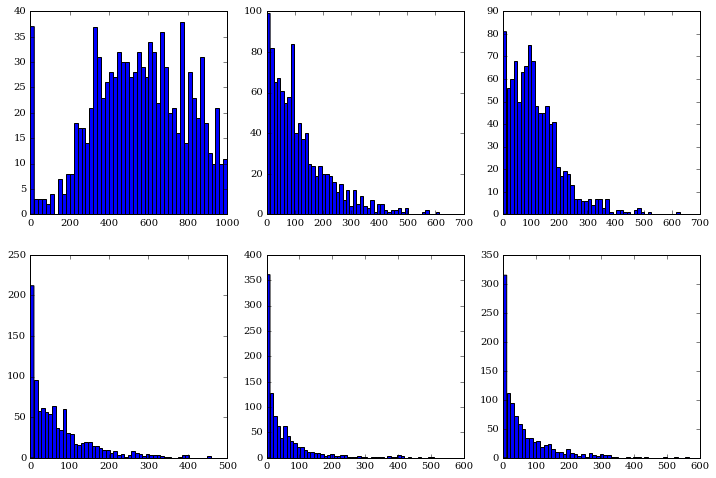

In [224]:
set_figsize(12,8)
plt.subplot(2,3,1)
plt.hist(all_segmented[all_segmented.stage_id == "1"].stage_prob1,bins=50)
plt.subplot(2,3,2)
plt.hist(all_segmented[all_segmented.stage_id == "1"].stage_prob2,bins=50)
plt.subplot(2,3,3)
plt.hist(all_segmented[all_segmented.stage_id == "1"].stage_prob3,bins=50)
plt.subplot(2,3,4)
plt.hist(all_segmented[all_segmented.stage_id == "1"].stage_prob4,bins=50)
plt.subplot(2,3,5)
plt.hist(all_segmented[all_segmented.stage_id == "1"].stage_prob5,bins=50)
plt.subplot(2,3,6)
plt.hist(all_segmented[all_segmented.stage_id == "1"].stage_prob6,bins=50)

(63235, 22)
(587, 22)
(1018, 22)


(array([ 12.,  17.,  11.,  15.,  13.,  21.,  10.,  17.,  14.,  16.,  16.,
         14.,  18.,  16.,  10.,  13.,  17.,  18.,  12.,  17.,   9.,  10.,
         13.,   7.,  10.,   8.,  18.,  18.,   4.,  10.,  11.,  17.,  13.,
         14.,   9.,   8.,  15.,  18.,   7.,   7.,   7.,   5.,   5.,   6.,
         12.,   8.,   7.,   5.,   7.,   2.]),
 array([  501.  ,   510.98,   520.96,   530.94,   540.92,   550.9 ,
          560.88,   570.86,   580.84,   590.82,   600.8 ,   610.78,
          620.76,   630.74,   640.72,   650.7 ,   660.68,   670.66,
          680.64,   690.62,   700.6 ,   710.58,   720.56,   730.54,
          740.52,   750.5 ,   760.48,   770.46,   780.44,   790.42,
          800.4 ,   810.38,   820.36,   830.34,   840.32,   850.3 ,
          860.28,   870.26,   880.24,   890.22,   900.2 ,   910.18,
          920.16,   930.14,   940.12,   950.1 ,   960.08,   970.06,
          980.04,   990.02,  1000.  ]),
 <a list of 50 Patch objects>)

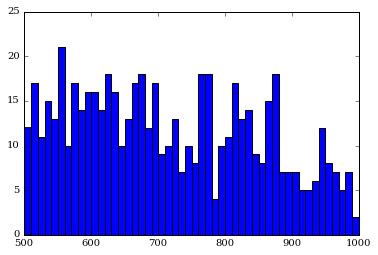

In [232]:
filter_annotated = all_segmented[((all_segmented.stage_id == "1") & (all_segmented.stage_prob1 > 500)) & \
                               ((((all_segmented.stage_prob2 < 400) & \
                                   (all_segmented.stage_prob3 < 400)) & \
                                ((all_segmented.stage_prob4 < 300) & \
                                    (all_segmented.stage_prob5 < 300))) & \
                                (all_segmented.stage_prob6 < 300))]

filter_all_stage1 = all_segmented[(all_segmented.stage_prob1 > 500) & \
                               ((((all_segmented.stage_prob2 < 400) & \
                                   (all_segmented.stage_prob3 < 400)) & \
                                ((all_segmented.stage_prob4 < 300) & \
                                    (all_segmented.stage_prob5 < 300))) & \
                                (all_segmented.stage_prob6 < 300))]

print filter_all.shape
print filter_annotated.shape
print all_segmented[(all_segmented.stage_id == "1")].shape
plt.hist(filter_annotated.stage_prob1,bins=50)

In [241]:
all_segmented.to_csv(all_seg_emb_out,sep='\t')

(array([ 17.,  42.,  36.,  45.,  40.,  52.,  52.,  65.,  67.,  62.,  70.,
         76.,  88.,  61.,  92.,  74.,  76.,  91.,  75.,  70.,  67.,  77.,
         75.,  78.,  69.,  60.,  41.,  26.,  12.,   6.]),
 array([  17.        ,   34.06666667,   51.13333333,   68.2       ,
          85.26666667,  102.33333333,  119.4       ,  136.46666667,
         153.53333333,  170.6       ,  187.66666667,  204.73333333,
         221.8       ,  238.86666667,  255.93333333,  273.        ,
         290.06666667,  307.13333333,  324.2       ,  341.26666667,
         358.33333333,  375.4       ,  392.46666667,  409.53333333,
         426.6       ,  443.66666667,  460.73333333,  477.8       ,
         494.86666667,  511.93333333,  529.        ]),
 <a list of 30 Patch objects>)

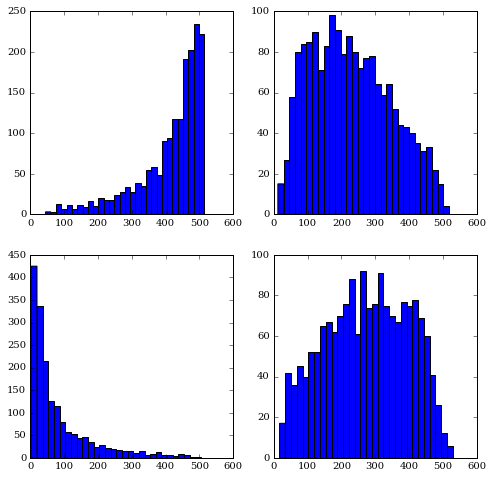

In [237]:
set_figsize(8,8)
plt.subplot(2,2,1)
plt.hist(all_segmented[all_segmented.flip == 'H'].flip_prob_h,bins=30)
plt.subplot(2,2,2)
plt.hist(all_segmented[all_segmented.flip == 'H'].flip_prob_i,bins=30)
plt.subplot(2,2,3)
plt.hist(all_segmented[all_segmented.flip == 'H'].flip_prob_v,bins=30)
plt.subplot(2,2,4)
plt.hist(all_segmented[all_segmented.flip == 'H'].flip_prob_x,bins=30)

(array([ 335.,  366.,  226.,  163.,  123.,   89.,   84.,   66.,   52.,
          41.,   47.,   46.,   36.,   28.,   35.,   16.,   18.,   15.,
          22.,   13.,   17.,   21.,   12.,    6.,    9.,    9.,    4.,
           6.,    2.,    1.]),
 array([   5.        ,   22.56666667,   40.13333333,   57.7       ,
          75.26666667,   92.83333333,  110.4       ,  127.96666667,
         145.53333333,  163.1       ,  180.66666667,  198.23333333,
         215.8       ,  233.36666667,  250.93333333,  268.5       ,
         286.06666667,  303.63333333,  321.2       ,  338.76666667,
         356.33333333,  373.9       ,  391.46666667,  409.03333333,
         426.6       ,  444.16666667,  461.73333333,  479.3       ,
         496.86666667,  514.43333333,  532.        ]),
 <a list of 30 Patch objects>)

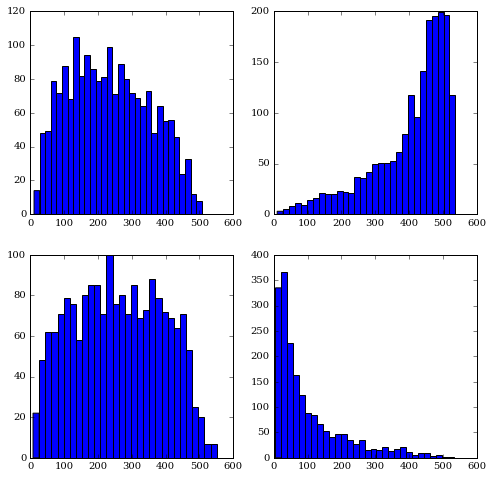

In [238]:
set_figsize(8,8)
plt.subplot(2,2,1)
plt.hist(all_segmented[all_segmented.flip == 'I'].flip_prob_h,bins=30)
plt.subplot(2,2,2)
plt.hist(all_segmented[all_segmented.flip == 'I'].flip_prob_i,bins=30)
plt.subplot(2,2,3)
plt.hist(all_segmented[all_segmented.flip == 'I'].flip_prob_v,bins=30)
plt.subplot(2,2,4)
plt.hist(all_segmented[all_segmented.flip == 'I'].flip_prob_x,bins=30)

(array([ 11.,  37.,  36.,  47.,  49.,  62.,  69.,  64.,  59.,  76.,  60.,
         59.,  58.,  66.,  48.,  56.,  52.,  47.,  20.,  59.,  40.,  38.,
         32.,  36.,  43.,  24.,  24.,  15.,   5.,   2.]),
 array([  12.        ,   28.76666667,   45.53333333,   62.3       ,
          79.06666667,   95.83333333,  112.6       ,  129.36666667,
         146.13333333,  162.9       ,  179.66666667,  196.43333333,
         213.2       ,  229.96666667,  246.73333333,  263.5       ,
         280.26666667,  297.03333333,  313.8       ,  330.56666667,
         347.33333333,  364.1       ,  380.86666667,  397.63333333,
         414.4       ,  431.16666667,  447.93333333,  464.7       ,
         481.46666667,  498.23333333,  515.        ]),
 <a list of 30 Patch objects>)

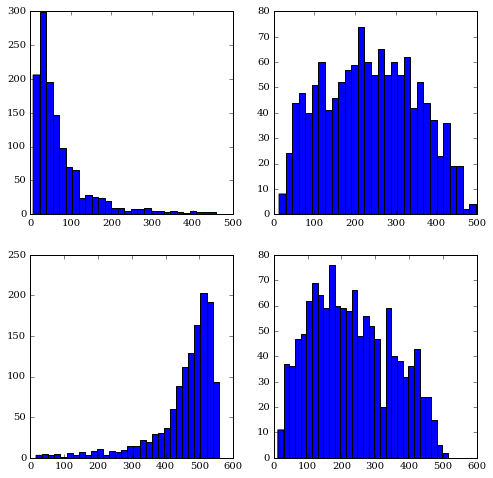

In [239]:
set_figsize(8,8)
plt.subplot(2,2,1)
plt.hist(all_segmented[all_segmented.flip == 'V'].flip_prob_h,bins=30)
plt.subplot(2,2,2)
plt.hist(all_segmented[all_segmented.flip == 'V'].flip_prob_i,bins=30)
plt.subplot(2,2,3)
plt.hist(all_segmented[all_segmented.flip == 'V'].flip_prob_v,bins=30)
plt.subplot(2,2,4)
plt.hist(all_segmented[all_segmented.flip == 'V'].flip_prob_x,bins=30)

(array([   2.,    0.,    0.,    4.,    4.,    2.,    6.,    5.,    3.,
           4.,    4.,    8.,    8.,    9.,   11.,   10.,   14.,   22.,
          19.,   25.,   28.,   27.,   48.,   59.,   76.,  152.,  166.,
         190.,  227.,  111.]),
 array([  41. ,   57.5,   74. ,   90.5,  107. ,  123.5,  140. ,  156.5,
         173. ,  189.5,  206. ,  222.5,  239. ,  255.5,  272. ,  288.5,
         305. ,  321.5,  338. ,  354.5,  371. ,  387.5,  404. ,  420.5,
         437. ,  453.5,  470. ,  486.5,  503. ,  519.5,  536. ]),
 <a list of 30 Patch objects>)

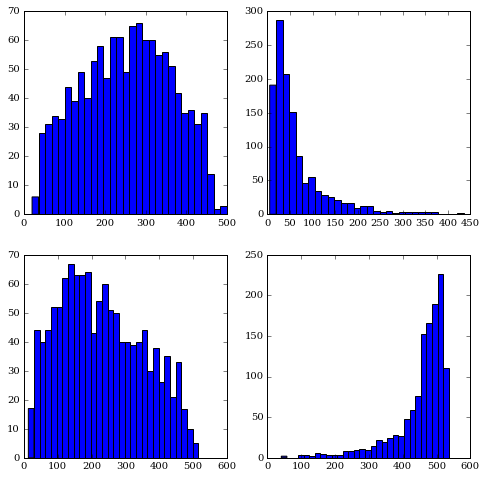

In [240]:
set_figsize(8,8)
plt.subplot(2,2,1)
plt.hist(all_segmented[all_segmented.flip == 'X'].flip_prob_h,bins=30)
plt.subplot(2,2,2)
plt.hist(all_segmented[all_segmented.flip == 'X'].flip_prob_i,bins=30)
plt.subplot(2,2,3)
plt.hist(all_segmented[all_segmented.flip == 'X'].flip_prob_v,bins=30)
plt.subplot(2,2,4)
plt.hist(all_segmented[all_segmented.flip == 'X'].flip_prob_x,bins=30)

(array([   1.,    5.,    8.,   12.,   20.,   24.,   21.,   36.,   30.,
          34.,   42.,   90.,   96.,   93.,   93.,  109.,  129.,  122.,
         129.,  133.,  146.,  163.,  190.,  170.,  215.,  209.,  228.,
         261.,  301.,  360.]),
 array([ 201.        ,  227.53333333,  254.06666667,  280.6       ,
         307.13333333,  333.66666667,  360.2       ,  386.73333333,
         413.26666667,  439.8       ,  466.33333333,  492.86666667,
         519.4       ,  545.93333333,  572.46666667,  599.        ,
         625.53333333,  652.06666667,  678.6       ,  705.13333333,
         731.66666667,  758.2       ,  784.73333333,  811.26666667,
         837.8       ,  864.33333333,  890.86666667,  917.4       ,
         943.93333333,  970.46666667,  997.        ]),
 <a list of 30 Patch objects>)

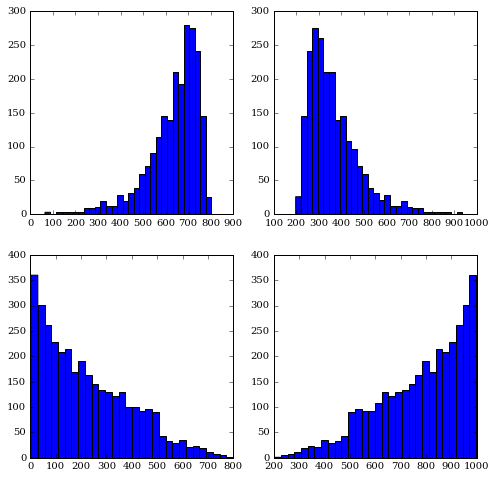

In [236]:
set_figsize(8,8)
plt.subplot(2,2,1)
plt.hist(all_segmented[all_segmented.orientation == 'D'].orientation_prob_d,bins=30)
plt.subplot(2,2,2)
plt.hist(all_segmented[all_segmented.orientation == 'D'].orientation_prob_l,bins=30)
plt.subplot(2,2,3)
plt.hist(all_segmented[all_segmented.orientation == 'L'].orientation_prob_d,bins=30)
plt.subplot(2,2,4)
plt.hist(all_segmented[all_segmented.orientation == 'L'].orientation_prob_l,bins=30)

In [107]:
all_emb_df.rename(index=str,columns={"embryo_id_x":"embryo_id"},inplace=True)

In [108]:
#all_emb_df = pd.read_csv(data_out_dir + "expression_patterns/filtered_embryo_images.tsv",sep="\t")
all_emb_df['tile_id'] = all_emb_df['scan_id'].apply((lambda x:re.search("^VT(\d+)",x).group(1)))
target_dir = data_out_dir + "expression_patterns/Stark_Tile_Images/"


In [190]:
all_predict_annot = pd.read_csv(data_out_dir + "expression_patterns/all_predict_annotations_prob_filter_1.2.tsv",sep="\t")
all_predict_annot['tile_id'] = all_predict_annot['scan_id'].apply((lambda x:re.search("^VT(\d+)",x).group(1)))
all_predict_annot.drop("embryo_id_y",axis=1)
all_predict_annot = all_predict_annot.rename(index=str,columns={'embryo_id_x':'embryo_id'})
all_positive_tiles = all_predict_annot.merge(stark2014_all_splt_pattern,how='inner',left_on='tile_id',right_on='VTID')
print all_positive_tiles.shape

(9130159, 39)


In [191]:
#stg1_predict_annot = pd.read_csv(data_out_dir + "expression_patterns/stage1_predict_annotations.tsv",sep="\t")
#stg1_predict_annot['VTID'] = stg1_predict_annot['scan_id'].apply((lambda x:re.search("^VT(\d+)",x).group(1))))
#stg1_predict_annot.drop("embryo_id_y",axis=1)
#stg1_predict_annot = stg1_predict_annot.rename(index=str,columns={'embryo_id_x':'embryo_id'})
all_positive_tiles["Stage"]

0            stg4_6
1            stg7_8
2           stg9_10
3          stg11_12
4          stg13_14
5          stg15_16
6            stg4_6
7            stg7_8
8           stg9_10
9          stg11_12
10         stg13_14
11         stg15_16
12           stg4_6
13           stg7_8
14          stg9_10
15         stg11_12
16         stg13_14
17         stg15_16
18           stg4_6
19           stg7_8
20          stg9_10
21         stg11_12
22         stg13_14
23         stg15_16
24           stg4_6
25           stg7_8
26          stg9_10
27         stg11_12
28         stg13_14
29         stg15_16
             ...   
9130129    stg13_14
9130130    stg13_14
9130131    stg15_16
9130132    stg15_16
9130133    stg15_16
9130134      stg4_6
9130135      stg7_8
9130136      stg7_8
9130137      stg7_8
9130138     stg9_10
9130139     stg9_10
9130140     stg9_10
9130141     stg9_10
9130142     stg9_10
9130143     stg9_10
9130144     stg9_10
9130145     stg9_10
9130146     stg9_10
9130147    stg11_12


In [192]:
#stg1_positive_tiles = stg1_predict_annot.merge(stark2014_all_splt_pattern,how='inner',left_on='tile_id',right_on='VTID')
stg1_positive_tiles = all_positive_tiles[(all_positive_tiles.Stage == "stg4_6") & ((all_positive_tiles.predict_stage_id == 1) & (all_positive_tiles.Pattern != 'None'))]
stg2_positive_tiles = all_positive_tiles[(all_positive_tiles.Stage == "stg7_8") & ((all_positive_tiles.predict_stage_id == 2) & (all_positive_tiles.Pattern != 'None'))]
stg3_positive_tiles = all_positive_tiles[(all_positive_tiles.Stage == "stg9_10") & ((all_positive_tiles.predict_stage_id == 3) & (all_positive_tiles.Pattern != 'None'))]

print stg1_positive_tiles.shape, stg2_positive_tiles.shape, stg3_positive_tiles.shape

(20861, 39) (19811, 39) (57482, 39)


In [193]:
print stg1_positive_tiles.head()

         X1  embryo_id  featured  selection  stage_id orientation flip  blur  \
13373  9237         34         0          0       NaN         NaN  NaN  7.41   
13541  9258         55         0          0       NaN         NaN  NaN  6.34   
13577  9266         63         0          0       NaN         NaN  NaN  2.97   
13889  9313        110         0          1       1.0           L    I  8.37   
14117  9348        145         0          1       1.0           L    I  8.37   

       intensity                       scan_id    ...       VTID  chr  \
13373      0.232  VT13671-metasys-20120601-bri    ...      13671   2R   
13541      0.812  VT13671-metasys-20120601-bri    ...      13671   2R   
13577      0.562  VT13671-metasys-20120601-bri    ...      13671   2R   
13889      0.862  VT13671-metasys-20120601-bri    ...      13671   2R   
14117      0.575  VT13671-metasys-20120601-bri    ...      13671   2R   

         start      end  Length  Verification_status  Positive   Stage  \
13373 

In [185]:
#stg1_positive_tiles = .merge(stark2014_all_splt_pattern,on=['VTID'])

def get_tile_image_means(positive_tiles,dim=(64,128)):
    tile_averages = []
    unique_positives = pd.unique(positive_tiles['tile_id'])
    for (i,tile) in enumerate(unique_positives):
        print "Working tile %s, %d of %d total..." % (tile,i,unique_positives.shape[0])
        tile_image_D_rows = positive_tiles[(positive_tiles.tile_id == tile)&(positive_tiles.predict_orientation == 'D')]
        tile_image_L_rows = positive_tiles[(positive_tiles.tile_id == tile)&(positive_tiles.predict_orientation == 'L')]
        if tile_image_D_rows.shape[0] > 0:
            D_image_rows = build_1D_img_df(tile_image_D_rows,dim=dim,flip_key='predict_flip')
            D_tile_mean = get_tile_embryo_images(tile,D_image_rows,img_cols=range(0,(dim[0]*dim[1]))).T
            D_tile_mean['orientation'] = "D"
            print "Tile %s: build mean D embryo from %d images" % (tile,D_image_rows.shape[0])
            tile_averages.append(D_tile_mean)
        if tile_image_L_rows.shape[0] > 0:
            L_image_rows = build_1D_img_df(tile_image_L_rows,dim=(64,128),flip_key='predict_flip')
            L_tile_mean = get_tile_embryo_images(tile,L_image_rows,img_cols=range(0,(dim[0]*dim[1]))).T
            L_tile_mean['orientation'] = "L"
            print "Tile %s: build mean L embryo from %d images" % (tile,L_image_rows.shape[0])
            tile_averages.append(L_tile_mean)
    tile_averages = pd.concat(tile_averages)
    return tile_averages
#stg1_predict_annot_img = build_1D_img_df(stg1_predict_annot,flip_key="predict_flip")

In [194]:
stg1_tile_averages = get_tile_image_means(stg1_positive_tiles)
stg1_tile_averages.to_csv(data_out_dir + "/expression_patterns/all_stg1_mean_embryo_images_pfilt.tsv",sep="\t")

Working tile 13671, 0 of 553 total...
Tile 13671: build mean D embryo from 3 images
Tile 13671: build mean L embryo from 10 images
Working tile 18574, 1 of 553 total...
Tile 18574: build mean D embryo from 1 images
Tile 18574: build mean L embryo from 14 images
Working tile 19840, 2 of 553 total...
Tile 19840: build mean D embryo from 3 images
Tile 19840: build mean L embryo from 9 images
Working tile 22223, 3 of 553 total...
Tile 22223: build mean D embryo from 22 images
Tile 22223: build mean L embryo from 60 images
Working tile 24047, 4 of 553 total...
Tile 24047: build mean D embryo from 9 images
Tile 24047: build mean L embryo from 20 images
Working tile 28544, 5 of 553 total...
Tile 28544: build mean D embryo from 7 images
Tile 28544: build mean L embryo from 30 images
Working tile 29398, 6 of 553 total...
Tile 29398: build mean D embryo from 7 images
Tile 29398: build mean L embryo from 17 images
Working tile 29579, 7 of 553 total...
Tile 29579: build mean D embryo from 10 image

In [195]:
stg2_tile_averages = get_tile_image_means(stg2_positive_tiles)
stg2_tile_averages.to_csv(data_out_dir + "/expression_patterns/all_stg2_mean_embryo_images_pfilt.tsv",sep="\t")

Working tile 27864, 0 of 652 total...
Tile 27864: build mean D embryo from 2 images
Tile 27864: build mean L embryo from 1 images
Working tile 13671, 1 of 652 total...
Tile 13671: build mean D embryo from 12 images
Tile 13671: build mean L embryo from 22 images
Working tile 14978, 2 of 652 total...
Tile 14978: build mean D embryo from 21 images
Tile 14978: build mean L embryo from 72 images
Working tile 19840, 3 of 652 total...
Tile 19840: build mean L embryo from 2 images
Working tile 22223, 4 of 652 total...
Tile 22223: build mean D embryo from 22 images
Tile 22223: build mean L embryo from 30 images
Working tile 24047, 5 of 652 total...
Tile 24047: build mean D embryo from 30 images
Tile 24047: build mean L embryo from 102 images
Working tile 29398, 6 of 652 total...
Tile 29398: build mean D embryo from 7 images
Tile 29398: build mean L embryo from 51 images
Working tile 29579, 7 of 652 total...
Tile 29579: build mean D embryo from 6 images
Tile 29579: build mean L embryo from 34 im

In [196]:
stg3_tile_averages = get_tile_image_means(stg3_positive_tiles)
stg3_tile_averages.to_csv(data_out_dir + "/expression_patterns/all_stg3_mean_embryo_images_pfilt.tsv",sep="\t")

Working tile 27864, 0 of 1249 total...
Tile 27864: build mean D embryo from 6 images
Tile 27864: build mean L embryo from 44 images
Working tile 28548, 1 of 1249 total...
Tile 28548: build mean D embryo from 9 images
Tile 28548: build mean L embryo from 55 images
Working tile 11173, 2 of 1249 total...
Tile 11173: build mean D embryo from 14 images
Tile 11173: build mean L embryo from 38 images
Working tile 13671, 3 of 1249 total...
Tile 13671: build mean D embryo from 5 images
Tile 13671: build mean L embryo from 7 images
Working tile 14978, 4 of 1249 total...
Tile 14978: build mean D embryo from 12 images
Tile 14978: build mean L embryo from 48 images
Working tile 18574, 5 of 1249 total...
Tile 18574: build mean D embryo from 14 images
Tile 18574: build mean L embryo from 96 images
Working tile 19840, 6 of 1249 total...
Tile 19840: build mean D embryo from 8 images
Tile 19840: build mean L embryo from 36 images
Working tile 22223, 7 of 1249 total...
Tile 22223: build mean D embryo fro

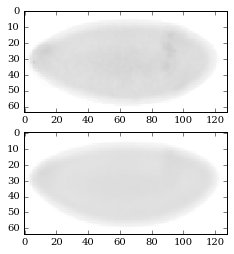

In [215]:
plt.subplot(2,1,1)
img_ar = np.array(stg1_tile_averages[(stg1_tile_averages.tile_id=='19013') & (stg1_tile_averages.orientation=='D')].iloc[:,0:8192],dtype=np.float)
plt.imshow(img_ar.reshape((64,128)),interpolation='none',cmap='Greys',vmin=0,vmax=1)
plt.subplot(2,1,2)
img_ar = np.array(stg1_tile_averages[(stg1_tile_averages.tile_id=='19013') & (stg1_tile_averages.orientation=='L')].iloc[:,0:8192],dtype=np.float)
plt.imshow(img_ar.reshape((64,128)),interpolation='none',cmap='Greys',vmin=0,vmax=1)


In [149]:
img_ar.min()

0.0

In [109]:
# Copy the images we want into the data directory - should only need to do this once

for r in all_emb_df.iterrows():
    row = r[1]
    emb_id = str(row["embryo_id"])
    emb_fname = "obj"+(4-len(emb_id))*"0"+emb_id
    src_dir = re.sub(img_st_dir,"",row['Scan_dir'])
    out_dir = os.path.join(target_dir,src_dir)
    if not os.path.exists(os.path.split(out_dir)[0]):
        os.mkdir(os.path.split(out_dir)[0])
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
    print ("copying VT %s %s" % (row['tile_id'],row['embryo_id']))
    shutil.copy(os.path.join(row['Scan_dir'],emb_fname + "-bri.png"),os.path.join(target_dir,src_dir,emb_fname + "-bri.png"))
    shutil.copy(os.path.join(row['Scan_dir'],emb_fname + "-mask.png"),os.path.join(target_dir,src_dir,emb_fname + "-mask.png"))

copying VT 18134 641
copying VT 18134 1281
copying VT 18134 2231
copying VT 18134 2411
copying VT 18134 2591
copying VT 18134 2631
copying VT 18134 2801
copying VT 18134 3131
copying VT 18134 3291
copying VT 18134 4551
copying VT 18134 4851
copying VT 13671 10
copying VT 13671 100
copying VT 13671 103
copying VT 13671 110
copying VT 13671 127
copying VT 13671 145
copying VT 13671 166
copying VT 13671 167
copying VT 13671 169
copying VT 13671 15
copying VT 13671 19
copying VT 13671 56
copying VT 13671 89
copying VT 13671 127
copying VT 13671 151
copying VT 14978 221
copying VT 14978 277
copying VT 18574 12
copying VT 18574 31
copying VT 18574 87
copying VT 18574 103
copying VT 18574 127
copying VT 18574 160
copying VT 18574 39
copying VT 18574 95
copying VT 18574 148
copying VT 18574 150
copying VT 18574 254
copying VT 18574 310
copying VT 18574 323
copying VT 18574 333
copying VT 19840 54
copying VT 19840 55
copying VT 19840 145
copying VT 19840 166
copying VT 19840 220
copying VT 1984

OSError: [Errno 2] No such file or directory: '/Users/barricklab/Dropbox/Documents/Manuscripts/slicing/analysis_notebook/data/expression_patterns/Stark_Tile_Images/vt-embryosTest/20120907'

In [110]:
#target_dir = data_out_dir + "/expression_patterns/Stark_Tile_Images/"
img_st_dir = "/Volumes/Terence_Howard/Data/Stark_embryo_images/"
all_emb_df['Scan_dir'] = all_emb_df['Scan_dir'].apply((lambda x: re.sub(img_st_dir,target_dir,x)))

In [204]:
all_emb_df[all_emb_df.tile_id == 47167]

Empty DataFrame
Columns: [Unnamed: 0, embryo_id, featured, selection, stage_id, orientation, flip, blur, intensity, scan_id, embryo_id_y, stage_prob1, stage_prob2, stage_prob3, stage_prob4, stage_prob5, stage_prob6, orientation_prob_l, orientation_prob_d, flip_prob_i, flip_prob_h, flip_prob_v, flip_prob_x, Scan_dir, tile_id]
Index: []

[0 rows x 25 columns]

In [112]:
all_emb_img = build_1D_img_df(all_emb_df)

{'scan_id': 'VT18134-metasys-20120525B-bri', 'embryo_id': 641}
{'scan_id': 'VT18134-metasys-20120525B-bri', 'embryo_id': 641}
{'scan_id': 'VT18134-metasys-20120525B-bri', 'embryo_id': 1281}
{'scan_id': 'VT18134-metasys-20120525B-bri', 'embryo_id': 2231}
{'scan_id': 'VT18134-metasys-20120525B-bri', 'embryo_id': 2411}
{'scan_id': 'VT18134-metasys-20120525B-bri', 'embryo_id': 2591}
{'scan_id': 'VT18134-metasys-20120525B-bri', 'embryo_id': 2631}
{'scan_id': 'VT18134-metasys-20120525B-bri', 'embryo_id': 2801}
{'scan_id': 'VT18134-metasys-20120525B-bri', 'embryo_id': 3131}
{'scan_id': 'VT18134-metasys-20120525B-bri', 'embryo_id': 3291}
{'scan_id': 'VT18134-metasys-20120525B-bri', 'embryo_id': 4551}
{'scan_id': 'VT18134-metasys-20120525B-bri', 'embryo_id': 4851}
{'scan_id': 'VT13671-metasys-20120601-bri', 'embryo_id': 10}
{'scan_id': 'VT13671-metasys-20120601-bri', 'embryo_id': 100}
{'scan_id': 'VT13671-metasys-20120601-bri', 'embryo_id': 103}
{'scan_id': 'VT13671-metasys-20120601-bri', 'embr

In [158]:
all_emb_img.to_csv(data_out_dir + "/expression_patterns/Serialized_Embryo_Images.tsv",sep="\t")

In [166]:
all_emb_img_stg1_L = all_emb_img[(all_emb_img['stage_id'] == 1) & (all_emb_img['orientation']=='L')]
all_emb_img_stg1_D = all_emb_img[(all_emb_img['stage_id'] == 1) & (all_emb_img['orientation']=='D')]
all_emb_img_stg1_L_tile_means = [(g[0],g[1][range(0,5000)].mean()) for g in all_emb_img_stg1_L.groupby('tile_id')]
all_emb_img_stg1_D_tile_means = [(g[0],g[1][range(0,5000)].mean()) for g in all_emb_img_stg1_D.groupby('tile_id')]
pd.DataFrame.from_dict(dict(all_emb_img_stg1_tile_means),orient='index')

0     1     2     3     4     5     6     7     8     9     ...   4990  \
0003    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
0006    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
0007    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
0013    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
0025    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
0108    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
0110    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
0112    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
0131    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
0132    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
0267    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
0268    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
0279    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
0768    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
0770    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
0830    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
0845    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
0850    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
0922    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
0983    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
0984    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
0985    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
10116   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
10135   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
10589   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
10670   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
10695   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
1082    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
1083    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
1085    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...    ...   
8450    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
8482    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
8483    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
8808    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
8888    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
8990    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
8996    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
9067    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
9076    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
9081    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
9084    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
9125    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
9229    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
9629    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
9652    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
9666    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
9669    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
9674    0.0   0.0   0.0   0.0   0.0   

In [169]:
len(all_emb_img_stg1_L_tile_means)

388

In [197]:
Am_gt_tile_overlap_uniq = Am_gt_anat_grp_VT.reset_index()
Pm_gt_tile_overlap_uniq = Pm_gt_anat_grp_VT.reset_index()
All_gt_tile_overlap_uniq = All_gt_anat_grp_VT.reset_index()
NDfdr1_gt_tile_overlap_uniq = NDfdr1_gt_anat_grp_VT.reset_index()

Am_stg4_6_unique_tiles = set(Am_gt_tile_overlap_uniq[Am_gt_tile_overlap_uniq["Stage"] == "stg4_6"]["VTID"])
Pm_stg4_6_unique_tiles = set(Pm_gt_tile_overlap_uniq[Pm_gt_tile_overlap_uniq["Stage"] == "stg4_6"]["VTID"])
All_stg4_6_unique_tiles = set(All_gt_tile_overlap_uniq[All_gt_tile_overlap_uniq["Stage"] == "stg4_6"]["VTID"])
NDfdr1_stg4_6_unique_tiles = set(NDfdr1_gt_tile_overlap_uniq[NDfdr1_gt_tile_overlap_uniq["Stage"] == "stg4_6"]["VTID"])

print len(Am_stg4_6_unique_tiles)
print len(Pm_stg4_6_unique_tiles)
print len(All_stg4_6_unique_tiles)
print len(NDfdr1_stg4_6_unique_tiles)

Am_gt_tile_overlap_uniq_L_rows = pd.concat([get_tile_embryo_images(int(tile),all_emb_img_stg1_L) for tile in Am_stg4_6_unique_tiles])#,ignore_index=True)
Am_gt_tile_overlap_uniq_L_rows

125
86
315
126


0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
5      NaN
6      NaN
7      NaN
8      NaN
9      NaN
10     NaN
11     NaN
12     NaN
13     NaN
14     NaN
15     NaN
16     NaN
17     NaN
18     NaN
19     NaN
20     NaN
21     NaN
22     NaN
23     NaN
24     NaN
25     NaN
26     NaN
27     NaN
28     NaN
29     NaN
        ..
4970   NaN
4971   NaN
4972   NaN
4973   NaN
4974   NaN
4975   NaN
4976   NaN
4977   NaN
4978   NaN
4979   NaN
4980   NaN
4981   NaN
4982   NaN
4983   NaN
4984   NaN
4985   NaN
4986   NaN
4987   NaN
4988   NaN
4989   NaN
4990   NaN
4991   NaN
4992   NaN
4993   NaN
4994   NaN
4995   NaN
4996   NaN
4997   NaN
4998   NaN
4999   NaN
dtype: float64

In [200]:
pd.concat([get_tile_embryo_images(tile,all_emb_img_stg1_L) for tile in Am_stg4_6_unique_tiles])

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
6       NaN
7       NaN
8       NaN
9       NaN
10      NaN
11      NaN
12      NaN
13      NaN
14      NaN
15      NaN
16      NaN
17      NaN
18      NaN
19      NaN
20      NaN
21      NaN
22      NaN
23      NaN
24      NaN
25      NaN
26      NaN
27      NaN
28      NaN
29      NaN
       ... 
4970    NaN
4971    NaN
4972    NaN
4973    NaN
4974    NaN
4975    NaN
4976    NaN
4977    NaN
4978    NaN
4979    NaN
4980    NaN
4981    NaN
4982    NaN
4983    NaN
4984    NaN
4985    NaN
4986    NaN
4987    NaN
4988    NaN
4989    NaN
4990    NaN
4991    NaN
4992    NaN
4993    NaN
4994    NaN
4995    NaN
4996    NaN
4997    NaN
4998    NaN
4999    NaN
dtype: object

In [161]:
#Am_gt_tile_overlap_uniq = Am_gt_anat_grp_VT.reset_index()
#Pm_gt_tile_overlap_uniq = Pm_gt_anat_grp_VT.reset_index()
#All_gt_tile_overlap_uniq = All_gt_anat_grp_VT.reset_index()
#NDfdr1_gt_tile_overlap_uniq = NDfdr1_gt_anat_grp_VT.reset_index()

Am_gt_tile_overlap_uniq_L_rows = pd.concat([get_tile_embryo_images(tile,all_emb_img_stg1_L) for tile in Am_gt_tile_overlap_uniq])#,ignore_index=True)
Am_gt_tile_overlap_uniq_L_rows.dropna(inplace=True)


Am_gt_tile_overlap_uniq_D_rows = Am_gt_tile_overlap_uniq["VTID"].apply(get_tile_embryo_images,args=(all_emb_img_stg1_D,))#,ignore_index=True)
Am_gt_tile_overlap_uniq_D_rows.dropna(inplace=True)

print "Am L: %s" % (str(Am_gt_tile_overlap_uniq_L_rows.shape))
print "Am D: %s" % (str(Am_gt_tile_overlap_uniq_D_rows.shape))

Pm_gt_tile_overlap_uniq_L_rows = Pm_gt_tile_overlap_uniq["VTID"].apply(get_tile_embryo_images,args=(all_emb_img_stg1_L,))#,ignore_index=True)
Pm_gt_tile_overlap_uniq_L_rows.dropna(inplace=True)


Pm_gt_tile_overlap_uniq_D_rows = Pm_gt_tile_overlap_uniq["VTID"].apply(get_tile_embryo_images,args=(all_emb_img_stg1_D,))#,ignore_index=True)
Pm_gt_tile_overlap_uniq_D_rows.dropna(inplace=True)

print "Pm L: %s" % (str(Pm_gt_tile_overlap_uniq_L_rows.shape))
print "Pm D: %s" % (str(Pm_gt_tile_overlap_uniq_D_rows.shape))

All_gt_tile_overlap_uniq_L_rows = All_gt_tile_overlap_uniq["VTID"].apply(get_tile_embryo_images,args=(all_emb_img_stg1_L,))#,ignore_index=True)
All_gt_tile_overlap_uniq_L_rows.dropna(inplace=True)


All_gt_tile_overlap_uniq_D_rows = All_gt_tile_overlap_uniq["VTID"].apply(get_tile_embryo_images,args=(all_emb_img_stg1_D,))#,ignore_index=True)
All_gt_tile_overlap_uniq_D_rows.dropna(inplace=True)

print "All L: %s" % (str(All_gt_tile_overlap_uniq_L_rows.shape))
print "All D: %s" % (str(All_gt_tile_overlap_uniq_D_rows.shape))

NoBias_gt_tile_overlap_uniq_L_rows = NDfdr1_gt_tile_overlap_uniq["VTID"].apply(get_tile_embryo_images,args=(all_emb_img_stg1_L,))#,ignore_index=True)
NoBias_gt_tile_overlap_uniq_L_rows.dropna(inplace=True)


NoBias_gt_tile_overlap_uniq_D_rows = NDfdr1_gt_tile_overlap_uniq["VTID"].apply(get_tile_embryo_images,args=(all_emb_img_stg1_D,))#,ignore_index=True)
NoBias_gt_tile_overlap_uniq_D_rows.dropna(inplace=True)

print "NoBias L: %s" % (str(NoBias_gt_tile_overlap_uniq_L_rows.shape))
print "NoBias D: %s" % (str(NoBias_gt_tile_overlap_uniq_D_rows.shape))


Am L: (456, 5001)
Am D: (213, 5001)
Pm L: (314, 5001)
Pm D: (151, 5001)
All L: (1049, 5001)
All D: (553, 5001)
NoBias L: (368, 5001)
NoBias D: (213, 5001)


In [163]:
NoBias_gt_tile_overlap_uniq_L_rows = NDfdr1_gt_tile_overlap_uniq["VTID"].apply(get_tile_embryo_images,args=(all_emb_img_stg1_L,))#,ignore_index=True)
NoBias_gt_tile_overlap_uniq_L_rows.dropna(inplace=True)
NoBias_gt_tile_overlap_uniq_L_rows.drop_duplicates()


NoBias_gt_tile_overlap_uniq_D_rows = NDfdr1_gt_tile_overlap_uniq["VTID"].apply(get_tile_embryo_images,args=(all_emb_img_stg1_D,))#,ignore_index=True)
NoBias_gt_tile_overlap_uniq_D_rows.dropna(inplace=True)
NoBias_gt_tile_overlap_uniq_L_rows.drop_duplicates()

print "NoBias L: %s" % (str(NoBias_gt_tile_overlap_uniq_L_rows.shape))
print "NoBias D: %s" % (str(NoBias_gt_tile_overlap_uniq_D_rows.shape))


NoBias L: (368, 5001)
NoBias D: (244, 5001)


In [ ]:
Am_gt_tile_overlap_uniq = Am_gt_anat_grp_VT.reset_index()
Pm_gt_tile_overlap_uniq = Pm_gt_anat_grp_VT.reset_index()
All_gt_tile_overlap_uniq = All_gt_anat_grp_VT.reset_index()
NDfdr1_gt_tile_overlap_uniq = NDfdr1_gt_anat_grp_VT.reset_index()

Am_gt_tile_overlap_uniq_rows = Am_gt_tile_overlap_uniq["VTID"].apply(get_tile_embryo_images,args=(all_emb_img_stg1,))#,ignore_index=True)
Am_gt_tile_overlap_uniq_rows = pd.DataFrame(Am_gt_tile_overlap_uniq_rows).drop_duplicates()

Pm_gt_tile_overlap_uniq_rows = Pm_gt_tile_overlap_uniq["VTID"].apply(get_tile_embryo_images,args=(all_emb_img_stg1,))#,ignore_index=True)
Pm_gt_tile_overlap_uniq_rows = pd.DataFrame(Pm_gt_tile_overlap_uniq_rows).drop_duplicates()

All_gt_tile_overlap_uniq_rows = All_gt_tile_overlap_uniq["VTID"].apply(get_tile_embryo_images,args=(all_emb_img_stg1,))#,ignore_index=True)
All_gt_tile_overlap_uniq_rows = pd.DataFrame(All_gt_tile_overlap_uniq_rows)

NDfdr1_gt_tile_overlap_uniq_rows = NDfdr1_gt_tile_overlap_uniq["VTID"].apply(get_tile_embryo_images,args=(all_emb_img_stg1,))#,ignore_index=True)
NDfdr1_gt_tile_overlap_uniq_rows = pd.DataFrame(NDfdr1_gt_tile_overlap_uniq_rows).drop_duplicates()

0
0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6            NaN
7            NaN
8            NaN
9            NaN
10           NaN
11           NaN
12           NaN
13           NaN
14           NaN
15           NaN
16           NaN
17           NaN
18           NaN
19           NaN
20           NaN
21           NaN
22           NaN
23           NaN
24           NaN
25           NaN
26           NaN
27           NaN
28           NaN
29           NaN
           ...  
4971         NaN
4972         NaN
4973         NaN
4974         NaN
4975         NaN
4976         NaN
4977         NaN
4978         NaN
4979         NaN
4980         NaN
4981         NaN
4982         NaN
4983         NaN
4984         NaN
4985         NaN
4986         NaN
4987         NaN
4988         NaN
4989         NaN
4990         NaN
4991         NaN
4992         NaN
4993         NaN
4994         NaN
4995         NaN
4996         NaN
4997         NaN
4998        

In [185]:
#Am_gt_tile_overlap_uniq_rows = Am_gt_tile_overlap_uniq["VTID"].apply(get_tile_embryo_images,args=(all_emb_img_stg1,))#,ignore_index=True)
all_emb_img[all_emb_img['tile_id'] == '37560']
#print Am_gt_tile_overlap_uniq_rows.iloc[11]
#print Am_gt_tile_overlap_uniq_rows[1250]
#Am_gt_tile_overlap_uniq_rows = pd.DataFrame(Am_gt_tile_overlap_uniq_rows).drop_duplicates()


Empty DataFrame
Columns: [Unnamed: 0, embryo_id, featured, selection, stage_id, orientation, flip, blur, intensity, scan_id, stage_prob1, stage_prob2, stage_prob3, stage_prob4, stage_prob5, stage_prob6, orientation_prob_l, orientation_prob_d, flip_prob_i, flip_prob_h, flip_prob_v, flip_prob_x, Scan_dir, tile_id, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, ...]
Index: []

[0 rows x 5024 columns]

In [164]:
Am_gt_tile_overlap_uniq_L_rows.to_csv(data_out_dir + "expression_patterns/Am_gt_Stark_tile_L_means_serialized.tsv",sep="\t")
Pm_gt_tile_overlap_uniq_L_rows.to_csv(data_out_dir + "expression_patterns/Pm_gt_Stark_tile_L_means_serialized.tsv",sep="\t")
All_gt_tile_overlap_uniq_L_rows.to_csv(data_out_dir + "expression_patterns/ALL_gt_Stark_tile_L_means_serialized.tsv",sep="\t")
NoBias_gt_tile_overlap_uniq_L_rows.to_csv(data_out_dir + "expression_patterns/NoBias_gt_Stark_tile_L_means_serialized.tsv",sep="\t")
Am_gt_tile_overlap_uniq_D_rows.to_csv(data_out_dir + "expression_patterns/Am_gt_Stark_tile_D_means_serialized.tsv",sep="\t")
Pm_gt_tile_overlap_uniq_D_rows.to_csv(data_out_dir + "expression_patterns/Pm_gt_Stark_tile_D_means_serialized.tsv",sep="\t")
All_gt_tile_overlap_uniq_D_rows.to_csv(data_out_dir + "expression_patterns/ALL_gt_Stark_tile_D_means_serialized.tsv",sep="\t")
NoBias_gt_tile_overlap_uniq_D_rows.to_csv(data_out_dir + "expression_patterns/NoBias_gt_Stark_tile_D_means_serialized.tsv",sep="\t")

In [42]:
Am_sample = Am_gt_tile_overlap_uniq_rows
ALL_sample = All_gt_tile_overlap_uniq_rows
print len(Am_sample)
#print all_emb_img[1250].to_string()
print Am_sample[1250].to_string()
test_bootstrap = bootstrap_pval(ALL_sample[1250],np.mean,Am_sample[1250],samples=10000,plot=True)

NameError: name 'Am_gt_tile_overlap_uniq_rows' is not defined

In [166]:
print Am_sample[1250].to_string()
print ALL_sample[1250].to_string()


0           NaN
1      0.705897
2           NaN
3           NaN
4      0.777315
5           NaN
6           NaN
7           NaN
8           NaN
9           NaN
10          NaN
11          NaN
12     0.712272
13          NaN
14          NaN
15          NaN
16          NaN
17     0.708266
18          NaN
19          NaN
20          NaN
21          NaN
22          NaN
23          NaN
24          NaN
25          NaN
26          NaN
27          NaN
28          NaN
29          NaN
30     0.668228
31     0.862306
32          NaN
33     0.724118
34     0.158539
35          NaN
36          NaN
37          NaN
38     0.475118
39          NaN
41          NaN
42     0.734868
43          NaN
44          NaN
45          NaN
46          NaN
47     0.706745
48     0.741176
49          NaN
50     0.819923
51     0.694338
52     0.817809
53     0.721475
54     0.797891
55          NaN
56          NaN
57          NaN
58          NaN
59          NaN
60     0.720158
61     0.766291
62     0.793533
63     0

In [114]:
Am_pvals = [(x,bootstrap_pval(all_emb_img_stg1[x], np.mean, Am_sample[x],idx=x)) for x in np.arange(1,5000)]
print Am_pvals
emb_img = np.zeros((5000,))
#emb_img[:] = -1
for (x,bsp) in Am_pvals:
    emb_img[x] = bsp[4] - bsp[3]
plt.imshow(emb_img.reshape((50,100)),interpolation='none')
plt.savefig("/Users/cwbrown/Dropbox/Documents/Manuscripts/slicing/analysis_notebook/figs/Am_fdr1_Stark_mean_emb_nopvalflt.pdf",format='pdf')


running 1 running 2 running 3 running 4 running 5 running 6 running 7 running 8 running 9 running 10 running 11 running 12 running 13 running 14 running 15 running 16 running 17 running 18 running 19 running 20 running 21 running 22 running 23 running 24 running 25 running 26 running 27 running 28 running 29 running 30 running 31 running 32 running 33 running 34 running 35 running 36 running 37 running 38 running 39 running 40 running 41 running 42 running 43 running 44 running 45 running 46 running 47 running 48 running 49 running 50 running 51 running 52 running 53 running 54 running 55 running 56 running 57 running 58 running 59 running 60 running 61 running 62 running 63 running 64 running 65 running 66 running 67 running 68 running 69 running 70 running 71 running 72 running 73 running 74 running 75 running 76 running 77 running 78 running 79 running 80 running 81 running 82 running 83 running 84 running 85 running 86 running 87 running 88 running 89 running 90 running 91 running 

/Users/barricklab/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:57: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


 bootstrap_mean: 0.000962 sample_stat: 0.007280 Rpval: 0.008500 Lpval: 0.877000 twotail_pval: 0.017000
running 247 bootstrap_mean: 0.001002 sample_stat: 0.007274 Rpval: 0.009100 Lpval: 0.872100 twotail_pval: 0.018200
running 248 bootstrap_mean: 0.000152 sample_stat: 0.001090 Rpval: 0.008200 Lpval: 0.868600 twotail_pval: 0.016400
running 249 bootstrap_mean: 0.000299 sample_stat: 0.002166 Rpval: 0.009700 Lpval: 0.871900 twotail_pval: 0.019400
running 250 bootstrap_mean: 0.000303 sample_stat: 0.002134 Rpval: 0.008500 Lpval: 0.866800 twotail_pval: 0.017000
running 251 bootstrap_mean: 0.000138 sample_stat: 0.001070 Rpval: 0.006900 Lpval: 0.878700 twotail_pval: 0.013800
running 252 bootstrap_mean: 0.000911 sample_stat: 0.006513 Rpval: 0.008500 Lpval: 0.868900 twotail_pval: 0.017000
running 253 bootstrap_mean: 0.000152 sample_stat: 0.001098 Rpval: 0.009500 Lpval: 0.871700 twotail_pval: 0.019000
running 254 running 255 running 256 running 257 running 258 running 259 running 260 running 261 run

KeyboardInterrupt: 